<a href="https://colab.research.google.com/github/im-karthikrajesh/hotel-booking-cancellations-geo-ml/blob/notebook3/Predictive_Modelling_and_Geospatial_Analysis_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Factors Driving Hotel Booking Cancellations: A Predictive and Geospatial Analysis**

### **Notebook 3: Predictive Modelling, Geospatial and Cross-Country Analysis**

**Environment Setup**

In [ ]:
# Install required packages
%pip install --quiet optuna category_encoders geopandas folium mapclassify dataframe-image libpysal esda

# Standard library
import os
from pathlib import Path
import warnings
import textwrap
from textwrap import fill

# Core scientific stack
import numpy as np
import pandas as pd
from tabulate import tabulate
from scipy import stats
from scipy.stats import chi2_contingency, spearmanr, loguniform, uniform
import scipy.sparse as sp
from scipy.sparse import issparse

# Plotting & viz
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mtick
from matplotlib.patches import Rectangle
from matplotlib.patches import Patch

# Geospatial
import geopandas as gpd
import folium
import mapclassify as mc
from libpysal.weights import KNN
from esda.moran import Moran, Moran_Local

# Encoders
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

# Scikit-learn: model building & utilities
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    cross_val_predict,
    cross_validate,
    RandomizedSearchCV
)

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    precision_recall_curve,
    roc_curve,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    make_scorer,
    brier_score_loss
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.inspection import PartialDependenceDisplay

# Gradient boosting
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Imbalanced learning
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler

# Optuna (hyperparameter tuning)
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_slice,
    plot_parallel_coordinate
)

# Model explainability & persistence
import shap
import joblib

# Pandas Display Configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.2/882.2 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 92.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.4/247.4 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.7/385.7 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 MB 17.8 MB/s eta 0:00:00


**Load the dataset**

In [ ]:
# Path to the cleaned dataset
DATA_PATH = '/content/bk_full_cleaned.csv'

# Load the CSV into a DataFrame
df = pd.read_csv(DATA_PATH)

# Quick sanity checks
print(f"Loaded DataFrame with {df.shape[0]} rows and {df.shape[1]} columns")
display(df.head())
display(df.info())


Loaded DataFrame with 119390 rows and 66 columns


hotel  is_canceled  lead_time  adults  children  babies meal country market_segment distribution_channel  is_repeated_guest  previous_cancellations  previous_bookings_not_canceled reserved_room_type assigned_room_type  booking_changes deposit_type  agent  days_in_waiting_list customer_type   adr  required_car_parking_spaces  total_of_special_requests reservation_status reservation_status_date arrival_date  arrival_year  total_nights  total_guests lead_time_bin  season  is_long_stay  flag_special_requests  flag_deposit_taken  flag_country_unknown  flag_lead_time_outlier  flag_adr_outlier  bookings_count  cancellation_rate  population_density  inflation_pct  mobile_subs_per100  internet_users_pct  gdp_growth_pct  gdp_per_capita_usd  unemployment_pct  pop_15_64_pct  pop_65_plus_pct  population_total  urban_pop_pct  tourism_departures  tourism_receipts_usd  booking_wdi_imputed  tourism_departures_per_1000  tourism_receipts_per_capita  tourism_share_of_gdp  real_gdp_growth_pct  \
0  Resort Hotel            0   5.837730       2         0       0   BB     PRT         Direct               Direct                  0                       0                               0                  C                  C                3   No Deposit   NONE                     0     Transient   0.0                            0                          0          Check-Out              2015-07-01   2015-07-01          2015             0             2         >180d  Summer             0                      0                   0                     0                       0                 0           13307           0.569775           113.07252       0.487939          113.016884                68.6        1.589798           19215.781            12.447       65.12699        20.574253         16.153276         63.514           14.453674          1.600700e+10                    0                     5.213609                     1545.364                 0.080             0.742889   
1  Resort Hotel            0   5.924256       2         0       0   BB     PRT         Direct               Direct                  0                       0                               0                  C                  C                3   No Deposit   NONE                     0     Transient   0.0                            0                          0          Check-Out              2015-07-01   2015-07-01          2015             0             2         >180d  Summer             0                      0                   0                     0                       1                 0           13307           0.569775           113.07252       0.487939          113.016884                68.6        1.589798           19215.781            12.447       65.12699        20.574253         16.153276         63.514           14.453674          1.600700e+10                    0                     5.213609                     1545.364                 0.080             0.742889   
2  Resort Hotel            0   2.079442       1         0       0   BB     GBR         Direct               Direct                  0                       0                               0                  A                  C                0   No Deposit   NONE                     0     Transient  75.0                            0                          0          Check-Out              2015-07-02   2015-07-01          2015             1             1          0-7d  Summer             0                      0                   0                     0                       0                 0            1356           0.084808           269.15314       0.368047          121.504890                92.0        2.222888           44964.390             5.517       64.34942        17.769980         17.991684         82.626           18.167322          6.766000e+09                    1                     7.084232                      103.907                 0.002             1.049072   
3  Resort 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 66 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  float64
 3   adults                          119390 non-null  int64  
 4   children                        119390 non-null  int64  
 5   babies                          119390 non-null  int64  
 6   meal                            119390 non-null  object 
 7   country                         119390 non-null  object 
 8   market_segment                  119390 non-null  object 
 9   distribution_channel            119390 non-null  object 
 10  is_repeated_guest               119390 non-null  int64  
 11  previous_cancellations          119390 non-null  int64  
 12  previous_booking

None

**Target Distribution**

+------------------+---------+--------------+
| Status           |   Count | Proportion   |
|------------------+---------+--------------|
| Not Canceled (0) |   75166 | 62.96%       |
| Canceled (1)     |   44224 | 37.04%       |
+------------------+---------+--------------+


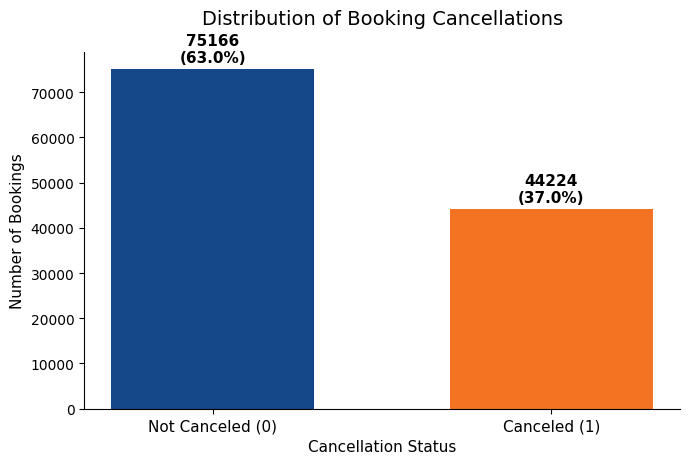

In [ ]:
# Compute counts and proportions
counts = df['is_canceled'].value_counts().sort_index()
props  = df['is_canceled'].value_counts(normalize=True).sort_index()

# Tabulate counts and proportions
dist_table = pd.DataFrame({
    'Status': ['Not Canceled (0)', 'Canceled (1)'],
    'Count': counts.values,
    'Proportion': [f"{p:.2%}" for p in props.values]
})
print(tabulate(dist_table, headers='keys', tablefmt='psql', showindex=False))

colors = ['#154889', '#f37322']  # dark blue, orange

fig, ax = plt.subplots(figsize=(7, 5))
bars = ax.bar([0, 1], counts.values, color=colors, width=0.6)

ax.set_xticks([0, 1])
ax.set_xticklabels(['Not Canceled (0)', 'Canceled (1)'], fontsize=11)
ax.set_ylabel('Number of Bookings', fontsize=11)
ax.set_xlabel('Cancellation Status', fontsize=11)
ax.set_title('Distribution of Booking Cancellations', fontsize=14, pad=20)

for idx, (bar, pct) in enumerate(zip(bars, props.values)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + counts.max()*0.01,
            f"{int(height)}\n({pct:.1%})", ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])
sns.despine()
plt.show()


**Correlation Checks**

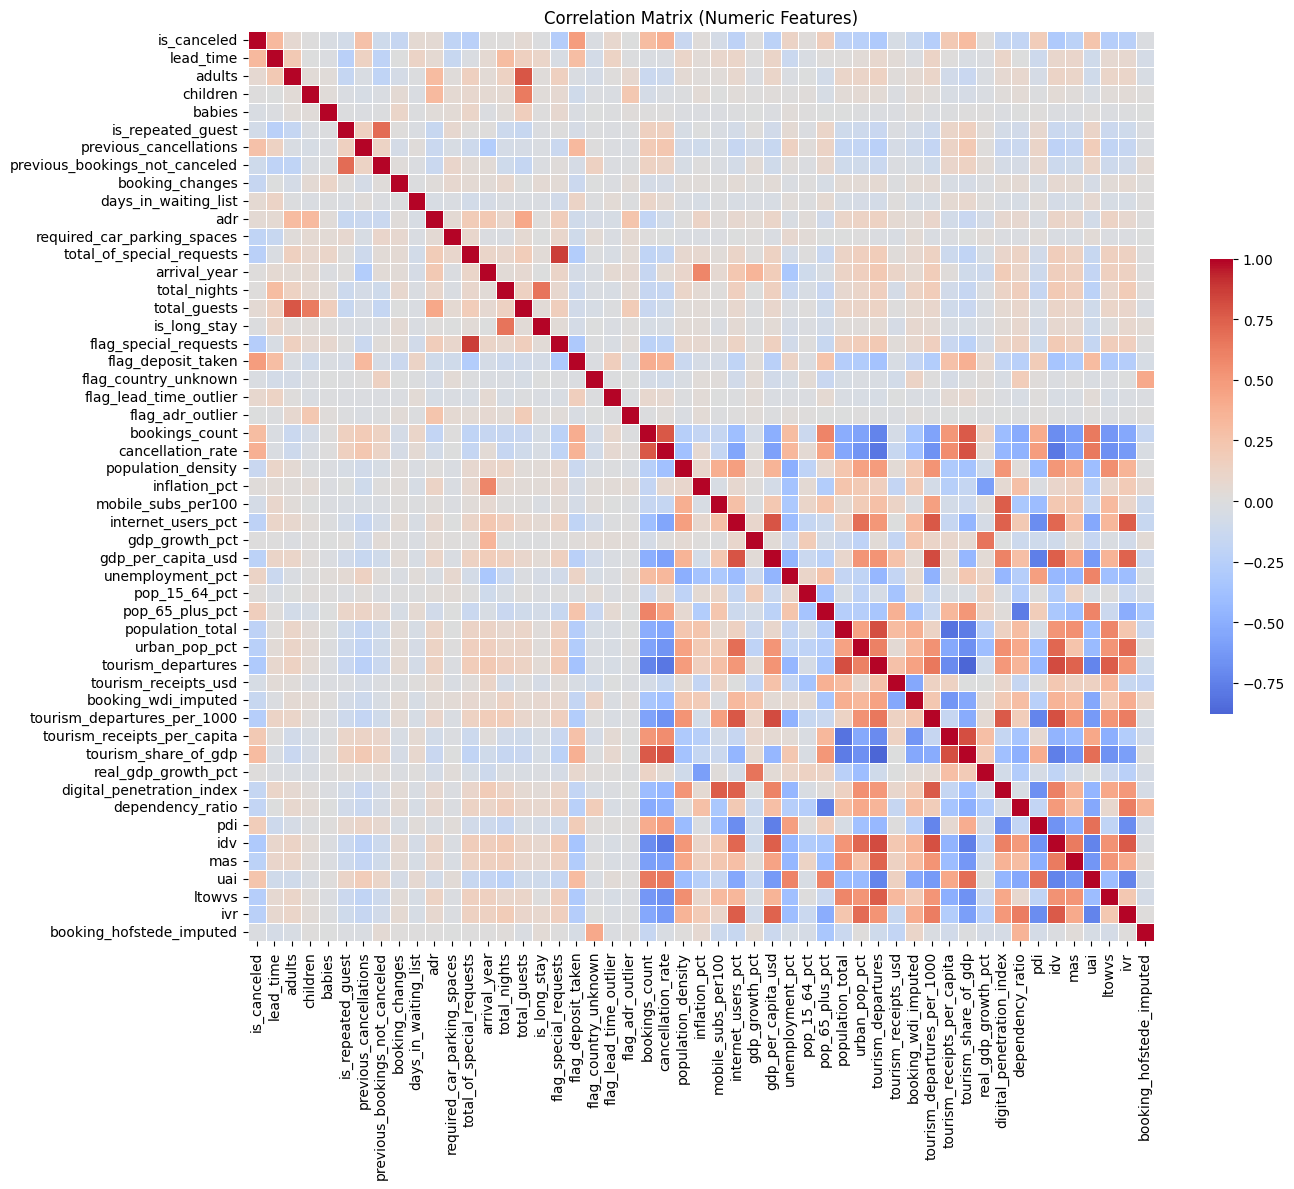

Numeric features sorted by Pearson correlation with 'is_canceled':


corr_with_is_canceled
flag_deposit_taken                           0.477911
cancellation_rate                            0.382161
lead_time                                    0.319135
tourism_share_of_gdp                         0.305572
bookings_count                               0.296561
previous_cancellations                       0.270943
uai                                          0.246119
tourism_receipts_per_capita                  0.212625
pdi                                          0.181764
pop_65_plus_pct                              0.166969
unemployment_pct                             0.125975
flag_lead_time_outlier                       0.078904
adults                                       0.063829
days_in_waiting_list                         0.054186
adr                                          0.052329
total_guests                                 0.046844
inflation_pct                                0.023748
pop_15_64_pct                                0.019354
arrival_year                                 0.016660
total_nights                                 0.015787
real_gdp_growth_pct                          0.015273
gdp_growth_pct                               0.005816
children                                     0.005368
flag_adr_outlier                            -0.001171
is_long_stay                                -0.005772
booking_hofstede_imputed                    -0.015653
flag_country_unknown                        -0.030926
babies                                      -0.034305
tourism_receipts_usd                        -0.056144
mobile_subs_per100                          -0.065419
is_repeated_guest                           -0.084793
previous_bookings_not_canceled              -0.103948
population_density                          -0.142637
booking_wdi_imputed                         -0.145627
booking_changes                             -0.160848
digital_penetration_index                   -0.170216
dependency_ratio                            -0.183486
required_car_parking_spaces                 -0.197399
population_total                            -0.211863
internet_users_pct                          -0.212709
gdp_per_capita_usd                          -0.221357
mas                                         -0.224468
total_of_special_requests                   -0.236163
ivr                                         -0.236859
urban_pop_pct                               -0.246188
tourism_departures_per_1000                 -0.256043
ltowvs                                      -0.259640
flag_special_requests                       -0.264706
idv                                         -0.301343
tourism_departures                          -0.304895

In [ ]:
# Correlation Matrix & Numeric Feature Correlations with Target

# Identify numeric columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
corr_matrix = df[num_cols].corr()

# Heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0,
            cbar_kws={'shrink': .5}, linewidths=.5)
plt.title('Correlation Matrix (Numeric Features)')
plt.tight_layout()

# Save the figure as PNG
plt.savefig("correlation_matrix.png", dpi=300, bbox_inches="tight")

plt.show()

# Extract & sort correlations with the target variable
corr_with_target = corr_matrix['is_canceled'].drop('is_canceled').sort_values(ascending=False)

print("Numeric features sorted by Pearson correlation with 'is_canceled':")
display(corr_with_target.to_frame(name='corr_with_is_canceled'))

In [ ]:
# Chi-Square Tests for Categorical Features vs. Cancellation

# Identify categorical columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Significance level
alpha = 0.05

# Loop through each categorical feature
for col in cat_cols:
    # Build contingency table
    contingency = pd.crosstab(df[col], df['is_canceled'])

    # Perform Chi-Square test
    chi2, p, dof, expected = chi2_contingency(contingency)

    # Interpretation
    print(f"Feature: {col}")
    print(f"  Chi² = {chi2:.4f}")
    print(f"  p-value = {p:.4f}")
    print(f"  Degrees of freedom = {dof}")
    print(f"  Expected frequencies shape = {expected.shape}")
    if p < alpha:
        print(f"→ p < {alpha}: '{col}' is associated with cancellation.\n")
    else:
        print(f"→ p >= {alpha}: '{col}' not associated with cancellation.\n")


Feature: hotel
  Chi² = 2224.9249
  p-value = 0.0000
  Degrees of freedom = 1
  Expected frequencies shape = (2, 2)
→ p < 0.05: 'hotel' is associated with cancellation.

Feature: meal
  Chi² = 304.2362
  p-value = 0.0000
  Degrees of freedom = 4
  Expected frequencies shape = (5, 2)
→ p < 0.05: 'meal' is associated with cancellation.

Feature: country
  Chi² = 15397.7572
  p-value = 0.0000
  Degrees of freedom = 176
  Expected frequencies shape = (177, 2)
→ p < 0.05: 'country' is associated with cancellation.

Feature: market_segment
  Chi² = 8497.2241
  p-value = 0.0000
  Degrees of freedom = 7
  Expected frequencies shape = (8, 2)
→ p < 0.05: 'market_segment' is associated with cancellation.

Feature: distribution_channel
  Chi² = 3745.7941
  p-value = 0.0000
  Degrees of freedom = 4
  Expected frequencies shape = (5, 2)
→ p < 0.05: 'distribution_channel' is associated with cancellation.

Feature: reserved_room_type
  Chi² = 647.8351
  p-value = 0.0000
  Degrees of freedom = 9
  Expe

In [ ]:
# Identifying features that's a perfect proxy for the target

# Numeric correlations
# drop the target
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('is_canceled')
# compute corrwith on the DataFrame
corrs = df[num_cols].corrwith(df['is_canceled']).abs().sort_values(ascending=False)

print("Highly correlated numeric features (|corr| > 0.9):")
print(corrs[corrs > 0.9])

# Categorical Cramér’s V
def cramers_v(x, y):
    cont = pd.crosstab(x, y)
    chi2 = chi2_contingency(cont)[0]
    n = cont.sum().sum()
    k = min(cont.shape) - 1
    return np.sqrt(chi2 / (n * k))

cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
v_scores = {col: cramers_v(df[col], df['is_canceled']) for col in cat_cols}
v_ser = pd.Series(v_scores).sort_values(ascending=False)

print("\nHigh Cramér’s V categorical features (V > 0.9):")
print(v_ser[v_ser > 0.9])


Highly correlated numeric features (|corr| > 0.9):
Series([], dtype: float64)

High Cramér’s V categorical features (V > 0.9):
reservation_status    1.0
dtype: float64


**Stand-alone confirmation script for Leaky Feature's**

In [ ]:
# Assume df is loaded and cleaned, and includes 'is_canceled'
X = df.drop(columns=['is_canceled'])
y = df['is_canceled']

# Features under test, suspecting these for target leakage:
leak_cols = [
    'reservation_status',        # perfect one-to-one map to target
    'reservation_status_date',   # only known when a cancellation occurs
    'cancellation_rate',         # country-year mean of cancellations (computed on full data)
    'bookings_count',            # country-year counts (includes canceled bookings)
    'assigned_room_type'         # assigned only at check-in, canceled never check in
]

print("Feature".ljust(35), "AUC")
print("-" * 55)

for col in leak_cols:
    # Extract single column
    X_temp = X[[col]].copy()

    # Cardinality-based encoding
    if X_temp[col].dtype.name in ('object','category'):
        n_lvls = X_temp[col].nunique()

        if n_lvls <= 10:
            # small-card → one-hot
            encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
            X_enc = encoder.fit_transform(X_temp)
        else:
            # high-card → target-encode
            te = TargetEncoder()
            X_enc = te.fit_transform(X_temp[col], y).values.reshape(-1, 1)
    else:
        # numeric → pass through
        X_enc = X_temp.values.reshape(-1, 1)

    # Scale if it’s a dense array
    if not issparse(X_enc):
        X_enc = StandardScaler().fit_transform(X_enc)

    # Stratified split
    X_tr, X_te, y_tr, y_te = train_test_split(
        X_enc, y,
        stratify=y,
        test_size=0.2,
        random_state=42
    )

    # Fit & score
    model = LogisticRegression(solver='liblinear', max_iter=500, random_state=42)
    model.fit(X_tr, y_tr)
    auc = roc_auc_score(y_te, model.predict_proba(X_te)[:,1])

    print(f"{col.ljust(35)} {auc:.3f}")


Feature                             AUC
-------------------------------------------------------
reservation_status                  1.000
reservation_status_date             0.771
cancellation_rate                   0.719
bookings_count                      0.659
assigned_room_type                  0.602


**Define X and y**

In [ ]:
# Setting X and y

LEAKY = [
    'reservation_status',        # 1:1 maps to is_canceled
    'reservation_status_date',   # only known when a cancellation happens
    'assigned_room_type',        # only set at check-in (cancels never check in)
    'bookings_count',            # country-year total, includes cancellations
    'cancellation_rate'          # country-year mean, computed on full data
]

# Drop the true “leaky” features
df_model = df.drop(columns=LEAKY)

# Ensure arrival_date is a datetime
df_model['arrival_date'] = pd.to_datetime(df_model['arrival_date'])

# Extract month & weekday, then drop the raw datetime
df_model['arr_month'] = df_model['arrival_date'].dt.month
df_model['arr_weekday'] = df_model['arrival_date'].dt.weekday
df_model.drop(columns=['arrival_date'], inplace=True)

# Cast temporal features to categorical for OHE
df_model['arrival_year'] = df_model['arrival_year'].astype('category')
df_model['arr_month'] = df_model['arr_month'].astype('category')
df_model['arr_weekday'] = df_model['arr_weekday'].astype('category')

# Cyclical encoding for arrival month

# Ensure month is an integer in [1, 12]
df_model['arr_month_num'] = df_model['arr_month'].astype(int)

# Map to the unit circle
df_model['arr_month_sin'] = np.sin(2 * np.pi * df_model['arr_month_num'] / 12)
df_model['arr_month_cos'] = np.cos(2 * np.pi * df_model['arr_month_num'] / 12)

# Drop the redundant columns
df_model.drop(columns=['arr_month', 'arr_month_num'], inplace=True)

# Cyclical encoding for arrival weekday

# Ensure weekday codes are integers in [0, 6]
df_model['arr_weekday_num'] = df_model['arr_weekday'].astype(int)

# Project onto the unit circle
df_model['arr_weekday_sin'] = np.sin(2 * np.pi * df_model['arr_weekday_num'] / 7)
df_model['arr_weekday_cos'] = np.cos(2 * np.pi * df_model['arr_weekday_num'] / 7)

# Remove the redundant columns
df_model.drop(columns=['arr_weekday', 'arr_weekday_num'], inplace=True)

print("Remaining features:", df_model.columns.tolist())

# Define X & y
X = df_model.drop(columns=['is_canceled'])
y = df_model['is_canceled']

print(f"Features X shape: {X.shape}")
print(f"Target y shape: {y.shape}")


Remaining features: ['hotel', 'is_canceled', 'lead_time', 'adults', 'children', 'babies', 'meal', 'country', 'market_segment', 'distribution_channel', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'reserved_room_type', 'booking_changes', 'deposit_type', 'agent', 'days_in_waiting_list', 'customer_type', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'arrival_year', 'total_nights', 'total_guests', 'lead_time_bin', 'season', 'is_long_stay', 'flag_special_requests', 'flag_deposit_taken', 'flag_country_unknown', 'flag_lead_time_outlier', 'flag_adr_outlier', 'population_density', 'inflation_pct', 'mobile_subs_per100', 'internet_users_pct', 'gdp_growth_pct', 'gdp_per_capita_usd', 'unemployment_pct', 'pop_15_64_pct', 'pop_65_plus_pct', 'population_total', 'urban_pop_pct', 'tourism_departures', 'tourism_receipts_usd', 'booking_wdi_imputed', 'tourism_departures_per_1000', 'tourism_receipts_per_capita', 'tourism_share_of_gdp', 'real_gdp_growt

**Stand-alone Script for Full Feature Table**

In [ ]:
# Feature dictionary
FEATURE_META = {
    # Core booking details & Arrival timing & seasonality
    "hotel": {"desc": "Hotel property type (e.g., City or Resort).", "type": "Categorical", "group": "A · Core booking"},
    "is_canceled": {"desc": "Target: whether the booking was cancelled (1) or not (0).", "type": "Binary (Target)", "group": "A · Core booking"},
    "lead_time": {"desc": "Days between booking date and arrival date.", "type": "Continuous (days)", "group": "A · Core booking"},
    "arrival_year": {"desc": "Year of arrival.", "type": "Categorical (Ordinal)", "group": "A · Core booking"},
    "season": {"desc": "Season of arrival derived from date.", "type": "Categorical", "group": "E · Arrival timing & seasonality"},
    "lead_time_bin": {"desc": "Binned version of lead_time (e.g., short/medium/long).", "type": "Categorical (Ordinal)", "group": "E · Arrival timing & seasonality"},
    "arr_month_sin": {"desc": "Cyclical encoding (sine) of arrival month.", "type": "Continuous (−1..1)", "group": "E · Arrival timing & seasonality"},
    "arr_month_cos": {"desc": "Cyclical encoding (cosine) of arrival month.", "type": "Continuous (−1..1)", "group": "E · Arrival timing & seasonality"},
    "arr_weekday_sin": {"desc": "Cyclical encoding (sine) of arrival weekday.", "type": "Continuous (−1..1)", "group": "E · Arrival timing & seasonality"},
    "arr_weekday_cos": {"desc": "Cyclical encoding (cosine) of arrival weekday.", "type": "Continuous (−1..1)", "group": "E · Arrival timing & seasonality"},

    # Guest composition & stay duration
    "adults": {"desc": "Number of adults in the booking.", "type": "Continuous (count)", "group": "B · Guest composition & stay duration"},
    "children": {"desc": "Number of children in the booking.", "type": "Continuous (count)", "group": "B · Guest composition & stay duration"},
    "babies": {"desc": "Number of babies in the booking.", "type": "Continuous (count)", "group": "B · Guest composition & stay duration"},
    "total_nights": {"desc": "Total nights of stay (weeknights + weekends).", "type": "Continuous (nights)", "group": "B · Guest composition & stay duration"},
    "total_guests": {"desc": "Total party size (adults + children + babies).", "type": "Continuous (count)", "group": "B · Guest composition & stay duration"},
    "is_long_stay": {"desc": "Flag for long stays (engineered threshold).", "type": "Binary", "group": "B · Guest composition & stay duration"},

    # Customer segment, channel & origin
    "meal": {"desc": "Meal plan (e.g., BB, HB, FB, SC).", "type": "Categorical", "group": "C · Customer segment, channel & origin"},
    "country": {"desc": "Guest country of origin (ISO code).", "type": "Categorical", "group": "C · Customer segment, channel & origin"},
    "market_segment": {"desc": "Market segment (e.g., Online TA, Groups).", "type": "Categorical", "group": "C · Customer segment, channel & origin"},
    "distribution_channel": {"desc": "Booking distribution channel (e.g., TA/TO, Direct).", "type": "Categorical", "group": "C · Customer segment, channel & origin"},
    "agent": {"desc": "Booking agent identifier; ‘no_agent’ when missing.", "type": "Categorical (ID)", "group": "C · Customer segment, channel & origin"},
    "customer_type": {"desc": "Customer type (e.g., Transient, Group).", "type": "Categorical", "group": "C · Customer segment, channel & origin"},

    # Booking history & customer behaviour
    "is_repeated_guest": {"desc": "Whether the guest is a repeat customer.", "type": "Binary", "group": "D · Booking history & customer behaviour"},
    "previous_cancellations": {"desc": "Past bookings that were cancelled.", "type": "Continuous (count)", "group": "D · Booking history & customer behaviour"},
    "previous_bookings_not_canceled": {"desc": "Past bookings not cancelled.", "type": "Continuous (count)", "group": "D · Booking history & customer behaviour"},
    "booking_changes": {"desc": "Number of changes made to the booking.", "type": "Continuous (count)", "group": "D · Booking history & customer behaviour"},
    "deposit_type": {"desc": "Deposit policy (No Deposit, Non-Refund, Refundable).", "type": "Categorical", "group": "D · Booking history & customer behaviour"},
    "flag_deposit_taken": {"desc": "Flag indicating any deposit was taken.", "type": "Binary", "group": "D · Booking history & customer behaviour"},
    "days_in_waiting_list": {"desc": "Days the booking stayed on the waiting list.", "type": "Continuous (days)", "group": "D · Booking history & customer behaviour"},
    "total_of_special_requests": {"desc": "Number of special requests made.", "type": "Continuous (count)", "group": "D · Booking history & customer behaviour"},
    "flag_special_requests": {"desc": "Flag for any special request present.", "type": "Binary", "group": "D · Booking history & customer behaviour"},
    "required_car_parking_spaces": {"desc": "Number of requested car parking spaces.", "type": "Continuous (count)", "group": "D · Booking history & customer behaviour"},
    "reserved_room_type": {"desc": "Reserved room type code.", "type": "Categorical", "group": "D · Booking history & customer behaviour"},

    # Pricing & anomaly flags
    "adr": {"desc": "Average Daily Rate: lodging revenue ÷ nights.", "type": "Continuous (currency)", "group": "F · Pricing & anomaly flags"},
    "flag_adr_outlier": {"desc": "Flag for ADR outliers.", "type": "Binary", "group": "F · Pricing & anomaly flags"},
    "flag_lead_time_outlier": {"desc": "Flag for lead_time outliers.", "type": "Binary", "group": "F · Pricing & anomaly flags"},

    # Data quality & imputation flags
    "flag_country_unknown": {"desc": "Flag for unknown/missing country.", "type": "Binary", "group": "G · Data quality & imputation flags"},
    "booking_wdi_imputed": {"desc": "Flag that any WDI feature was imputed.", "type": "Binary", "group": "G · Data quality & imputation flags"},
    "booking_hofstede_imputed": {"desc": "Flag that any Hofstede feature was imputed.", "type": "Binary", "group": "G · Data quality & imputation flags"},

    # External context (WDI)
    "population_density": {"desc": "People per km².", "type": "Continuous", "group": "H · External (WDI)"},
    "inflation_pct": {"desc": "Annual inflation rate (%).", "type": "Continuous (%)", "group": "H · External (WDI)"},
    "mobile_subs_per100": {"desc": "Mobile subscriptions per 100 people.", "type": "Continuous", "group": "H · External (WDI)"},
    "internet_users_pct": {"desc": "Internet users (% of population).", "type": "Continuous (%)", "group": "H · External (WDI)"},
    "gdp_growth_pct": {"desc": "GDP growth (annual %).", "type": "Continuous (%)", "group": "H · External (WDI)"},
    "gdp_per_capita_usd": {"desc": "GDP per capita (USD).", "type": "Continuous (USD)", "group": "H · External (WDI)"},
    "unemployment_pct": {"desc": "Unemployment rate (% of labor force).", "type": "Continuous (%)", "group": "H · External (WDI)"},
    "pop_15_64_pct": {"desc": "Working-age population share (15–64).", "type": "Continuous (%)", "group": "H · External (WDI)"},
    "pop_65_plus_pct": {"desc": "Population share aged 65+.", "type": "Continuous (%)", "group": "H · External (WDI)"},
    "population_total": {"desc": "Total population.", "type": "Continuous", "group": "H · External (WDI)"},
    "urban_pop_pct": {"desc": "Urban population share.", "type": "Continuous (%)", "group": "H · External (WDI)"},
    "tourism_departures": {"desc": "Outbound tourism departures (count).", "type": "Continuous", "group": "H · External (WDI)"},
    "tourism_receipts_usd": {"desc": "Inbound tourism receipts (USD).", "type": "Continuous (USD)", "group": "H · External (WDI)"},
    "tourism_departures_per_1000": {"desc": "Outbound departures per 1,000 people.", "type": "Continuous", "group": "H · External (WDI)"},
    "tourism_receipts_per_capita": {"desc": "Tourism receipts per person (USD).", "type": "Continuous (USD)", "group": "H · External (WDI)"},
    "tourism_share_of_gdp": {"desc": "Tourism receipts as % of GDP.", "type": "Continuous (%)", "group": "H · External (WDI)"},
    "real_gdp_growth_pct": {"desc": "GDP growth minus inflation (approx.).", "type": "Continuous (%)", "group": "H · External (WDI)"},
    "digital_penetration_index": {"desc": "Avg. of internet_users_pct & mobile_subs_per100 (scaled).", "type": "Continuous (index)", "group": "H · External (WDI)"},
    "dependency_ratio": {"desc": "Dependents (0–14 & 65+) to working-age (15–64).", "type": "Continuous (ratio)", "group": "H · External (WDI)"},

    # External context (Hofstede)
    "pdi": {"desc": "Power Distance Index (0–100).", "type": "Continuous (index)", "group": "I · External (Hofstede)"},
    "idv": {"desc": "Individualism vs Collectivism (0–100).", "type": "Continuous (index)", "group": "I · External (Hofstede)"},
    "mas": {"desc": "Masculinity vs Femininity (0–100).", "type": "Continuous (index)", "group": "I · External (Hofstede)"},
    "uai": {"desc": "Uncertainty Avoidance (0–100).", "type": "Continuous (index)", "group": "I · External (Hofstede)"},
    "ltowvs": {"desc": "Long-Term Orientation (0–100).", "type": "Continuous (index)", "group": "I · External (Hofstede)"},
    "ivr": {"desc": "Indulgence vs Restraint (0–100).", "type": "Continuous (index)", "group": "I · External (Hofstede)"},
}

GROUP_ORDER = {
    "A · Core booking": 1,
    "B · Guest composition & stay duration": 2,
    "C · Customer segment, channel & origin": 3,
    "D · Booking history & customer behaviour": 4,
    "E · Arrival timing & seasonality": 5,
    "F · Pricing & anomaly flags": 6,
    "G · Data quality & imputation flags": 7,
    "H · External (WDI)": 8,
    "I · External (Hofstede)": 9,
}

# Columns that exist in df_model
cols = [c for c in df_model.columns if c in FEATURE_META]
rows = []
for c in cols:
    meta = FEATURE_META[c]
    rows.append({
        "Variable": c,
        "Description": meta["desc"],
        "Type": meta["type"],
        "Group": meta["group"],
        "_order": GROUP_ORDER.get(meta["group"], 999)
    })

feature_tbl = (pd.DataFrame(rows)
                 .sort_values(by=["_order", "Variable"])
                 .drop(columns="_order")
                 .reset_index(drop=True))

def style_feature_table(df, caption="Summary of dataset variables for hotel booking cancellation prediction."):
    styler = (
        df.style
          .hide(axis="index")
          .set_caption(caption)
          .set_table_styles([
              {"selector": "caption", "props": [("caption-side", "top"), ("font-weight", "bold"), ("font-size", "14pt"), ("text-align", "left")]},
              {"selector": "th", "props": [("background-color", "#0b5394"), ("color", "white"), ("font-weight", "600"), ("text-transform", "uppercase"), ("padding", "8px 10px")]},
              {"selector": "td", "props": [("vertical-align", "top"), ("padding", "8px 10px")]},
              {"selector": "tbody tr:nth-child(even)", "props": [("background-color", "#f6f8fa")]},
              {"selector": "tbody tr:hover", "props": [("background-color", "#eaf2ff")]}
          ])
          .set_properties(subset=["Variable"], **{"width": "180px"})
          .set_properties(subset=["Description"], **{"width": "700px"})
          .set_properties(subset=["Type"], **{"width": "200px"})
          .set_properties(subset=["Group"], **{"width": "220px"})
    )
    return styler

display(style_feature_table(feature_tbl))

# Save as PNG
def save_feature_table_png(df, png_path="feature_summary.png", html_path="feature_summary.html", wrap_desc=70):
    # Wrap long description text for better PNG layout
    df_wrapped = df.copy()
    df_wrapped["Description"] = df_wrapped["Description"].apply(lambda s: fill(s, wrap_desc))

    # Dataframe_image first for high-quality PNG
    try:
        import dataframe_image as dfi
        dfi.export(style_feature_table(df_wrapped), png_path, table_conversion="matplotlib", dpi=300)
        print(f"Saved PNG :- {png_path}")
    except Exception as e:
        # Fallback: save a styled HTML if dataframe_image isn't available
        with open(html_path, "w", encoding="utf-8") as f:
            f.write(style_feature_table(df).to_html())
        print(f"PNG export unavailable ({e}). Saved HTML instead :- {html_path}")

save_feature_table_png(feature_tbl, png_path="Feature_summary.png")


Saved PNG :- Feature_summary.png


In [ ]:
# Identify and Print Features Separately

# Identify numeric and categorical columns in X
numeric_feats = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_feats = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

# Categorical features
print("Categorical Features:")
for feat in categorical_feats:
    print(f" - {feat}")

# Numeric features
print("\nNumeric Features:")
for feat in numeric_feats:
    print(f" - {feat}")


Categorical Features:
 - hotel
 - meal
 - country
 - market_segment
 - distribution_channel
 - reserved_room_type
 - deposit_type
 - agent
 - customer_type
 - arrival_year
 - lead_time_bin
 - season

Numeric Features:
 - lead_time
 - adults
 - children
 - babies
 - is_repeated_guest
 - previous_cancellations
 - previous_bookings_not_canceled
 - booking_changes
 - days_in_waiting_list
 - adr
 - required_car_parking_spaces
 - total_of_special_requests
 - total_nights
 - total_guests
 - is_long_stay
 - flag_special_requests
 - flag_deposit_taken
 - flag_country_unknown
 - flag_lead_time_outlier
 - flag_adr_outlier
 - population_density
 - inflation_pct
 - mobile_subs_per100
 - internet_users_pct
 - gdp_growth_pct
 - gdp_per_capita_usd
 - unemployment_pct
 - pop_15_64_pct
 - pop_65_plus_pct
 - population_total
 - urban_pop_pct
 - tourism_departures
 - tourism_receipts_usd
 - booking_wdi_imputed
 - tourism_departures_per_1000
 - tourism_receipts_per_capita
 - tourism_share_of_gdp
 - real_gd

**Train/Test Split & Preprocessing Pipeline**

In [ ]:
# Train/Test Split & Preprocessing Pipeline

# 80/20 stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)
print("Shapes:")
print(f" X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f" X_test: {X_test.shape}, y_test: {y_test.shape}\n")

# Verify that cancellation rates are the same in both splits
train_rate = y_train.mean()
test_rate = y_test.mean()
print(f"Cancellation rate (train): {train_rate:.2%}")
print(f"Cancellation rate (test): {test_rate:.2%}")

# Identify feature types
numeric_feats = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_feats = X_train.select_dtypes(include=['object','category','bool']).columns.tolist()

# Cardinality split
card = X_train[categorical_feats].nunique().sort_values()
low_card_feats = card[card <= 10].index.tolist()
high_card_feats = card[card > 10].index.tolist()

print("Low‐cardinality:", low_card_feats)
print("High‐cardinality:", high_card_feats, "\n")

numeric_pipe = Pipeline([
    ('scale', StandardScaler())
])
ohe_pipe = Pipeline([
    ('encode', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])
tgt_pipe = Pipeline([
    ('te', TargetEncoder(smoothing=0.1)) # smoothing helps stabilize rare levels
])

# Build preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipe, numeric_feats),
        ('ohe', ohe_pipe, low_card_feats),
        ('tgt', tgt_pipe, high_card_feats),
    ],
    remainder='drop',
    verbose_feature_names_out=False
)


Shapes:
 X_train: (95512, 63), y_train: (95512,)
 X_test: (23878, 63), y_test: (23878,)

Cancellation rate (train): 37.04%
Cancellation rate (test): 37.04%
Low‐cardinality: ['hotel', 'deposit_type', 'arrival_year', 'customer_type', 'season', 'lead_time_bin', 'distribution_channel', 'meal', 'market_segment', 'reserved_room_type']
High‐cardinality: ['country', 'agent'] 



**Predictive Modelling**

In [ ]:
# Unfitted template of the original transformer

PREPROCESSOR_TMPL = preprocessor # unfitted ColumnTransformer

# Helper
def fresh_preprocessor():
    return clone(PREPROCESSOR_TMPL)

In [ ]:
# Utility Helper Functions

def prepare_test_df(X_train: pd.DataFrame, X_test) -> pd.DataFrame:
    """
    Return X_test as a DataFrame with exactly the same columns,
    index, and dtypes as X_train.  Extras in X_test are dropped, missing
    columns become NaN, then cast back to the original dtype.
    """
    # Build base DataFrame (preserve index if X_test is a DataFrame)
    if isinstance(X_test, pd.DataFrame):
        df = X_test.copy()
    else:
        idx = getattr(X_test, 'index', None)
        df = pd.DataFrame(X_test, columns=X_train.columns, index=idx)

    # Reindex to match X_train.columns exactly
    df = df.reindex(columns=X_train.columns)

    # Cast each column to the original dtype
    for col in X_train.columns:
        orig_dtype = X_train[col].dtype

        if isinstance(orig_dtype, pd.CategoricalDtype):
            df[col] = pd.Categorical(
                df[col],
                categories=X_train[col].cat.categories,
                ordered=X_train[col].cat.ordered
            )
        else:
            # numeric, object, bool, datetime, etc.
            df[col] = df[col].astype(orig_dtype, errors='ignore')
    return df


In [ ]:
# Utility Helper Functions

def plot_confusion(cm, title):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def evaluate_holdout(pipe, X_test, y_test, name, threshold=0.5):
    """
    Compute and print single hold-out metrics and plot the confusion matrix,
    then return a dict of the metrics for the summary table.
    """
    # Predict
    y_prob = pipe.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= threshold).astype(int)

    # Compute metrics
    auc       = roc_auc_score(y_test, y_prob)
    accuracy  = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall    = recall_score(y_test, y_pred)
    f1        = f1_score(y_test, y_pred)

    # Report
    print(f"-- Test ROC-AUC ({name}): {auc:.4f}")
    print(f"-- Classification Report ({name}):\n"
          f"{classification_report(y_test, y_pred)}")

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion(cm, f"{name}\nConfusion Matrix")

    # Return formatted metrics
    return {
        'ROC-AUC'  : f"{auc:.4f}",
        'Accuracy' : f"{accuracy:.4f}",
        'Precision': f"{precision:.4f}",
        'Recall'   : f"{recall:.4f}",
        'F1 Score' : f"{f1:.4f}"
    }

def cross_validate_metrics(pipe, X, y, cv_splits=5, return_per_fold=False):
    """
    5-fold stratified CV on (X, y) with common classification metrics.
    Returns mean±std strings.
    """
    scoring = {
        'roc_auc'  : 'roc_auc',
        'accuracy' : 'accuracy',
        'precision': 'precision',
        'recall'   : 'recall',
        'f1'       : 'f1'
    }
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
    results = cross_validate(
        pipe, X, y,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=False,
    )

    print(f"\nCross-validation metrics ({cv_splits}-fold):")
    summary = {}
    for metric in scoring:
        arr = np.asarray(results[f'test_{metric}'], dtype=float)
        mean, std = np.mean(arr), np.std(arr, ddof=1)
        print(f"{metric:>8}: {mean:.4f} ± {std:.4f}")
        label = metric.upper() if metric != 'f1' else 'F1 Score'
        summary[label] = f"{mean:.4f} ± {std:.4f}"

    return summary

**Dummy Classifier**

Dummy CV ROC-AUC: 0.4979 ± 0.0027

Cross-validation metrics (5-fold):
 roc_auc: 0.4979 ± 0.0030
accuracy: 0.5324 ± 0.0028
precision: 0.3677 ± 0.0038
  recall: 0.3645 ± 0.0038
      f1: 0.3661 ± 0.0038
-- Test ROC-AUC (Dummy Classifier): 0.5028
-- Classification Report (Dummy Classifier):
              precision    recall  f1-score   support

           0       0.63      0.63      0.63     15033
           1       0.37      0.37      0.37      8845

    accuracy                           0.54     23878
   macro avg       0.50      0.50      0.50     23878
weighted avg       0.54      0.54      0.54     23878



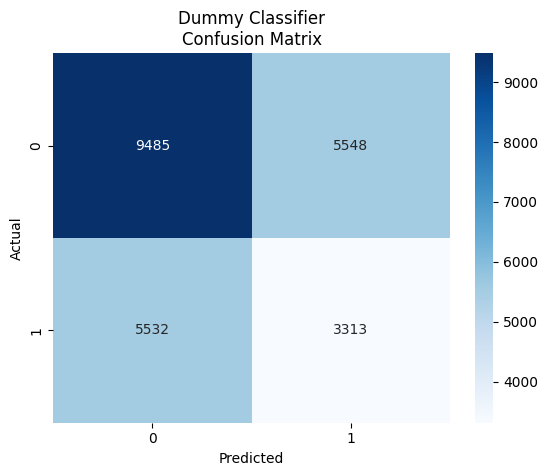

In [ ]:
# Baseline with stratified DummyClassifier

def run_dummy_classifier(X_train, y_train, X_test, y_test):
    X_test_df = prepare_test_df(X_train, X_test)
    pipe = Pipeline([
        ('preprocessor', fresh_preprocessor()),
        ('dummy', DummyClassifier(strategy='stratified', random_state=42))
    ])
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # 5-fold
    cv_scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
    print(f"Dummy CV ROC-AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    pipe.fit(X_train, y_train)
    cv_summary = cross_validate_metrics(pipe, X_train, y_train, cv_splits=5)
    holdout_summary = evaluate_holdout(pipe, X_test_df, y_test, 'Dummy Classifier')
    return pipe, cv_summary, holdout_summary

dummy_pipe, dummy_cv, dummy_holdout = run_dummy_classifier(X_train, y_train, X_test, y_test)

**Logistic Regression**

[I 2025-08-28 19:20:33,592] A new study created in memory with name: no-name-9e22fa98-62b8-4274-8e78-6fdda34f1a7b
[I 2025-08-28 19:20:46,629] Trial 0 finished with value: 0.9080864547557562 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.0060252157362038605, 'tol': 0.00013066739238053285, 'class_weight': None, 'max_iter': 2000, 'fit_intercept': True}. Best is trial 0 with value: 0.9080864547557562.
[I 2025-08-28 19:20:46,632] Trial 1 pruned. 
[I 2025-08-28 19:21:30,233] Trial 2 finished with value: 0.9120270925986501 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 0.19069966103000435, 'tol': 0.0037183641805732083, 'class_weight': 'balanced', 'max_iter': 2000, 'fit_intercept': True}. Best is trial 2 with value: 0.9120270925986501.
[I 2025-08-28 19:22:07,397] Trial 3 finished with value: 0.912209433859724 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 2.6373339933815254, 'tol': 0.0007591104805282694, 'class_weight': 'balanced', 'max_iter': 1000, 'f

Best LR hyper-parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 2.6373339933815254, 'tol': 0.0007591104805282694, 'class_weight': 'balanced', 'max_iter': 1000, 'fit_intercept': True}
Best CV ROC-AUC: 0.9122

Cross-validation metrics (5-fold):
 roc_auc: 0.9122 ± 0.0018
accuracy: 0.8284 ± 0.0017
precision: 0.7471 ± 0.0030
  recall: 0.8114 ± 0.0053
      f1: 0.7779 ± 0.0024
-- Test ROC-AUC (Logistic Regression): 0.9106
-- Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.88      0.84      0.86     15033
           1       0.75      0.81      0.78      8845

    accuracy                           0.83     23878
   macro avg       0.81      0.82      0.82     23878
weighted avg       0.83      0.83      0.83     23878



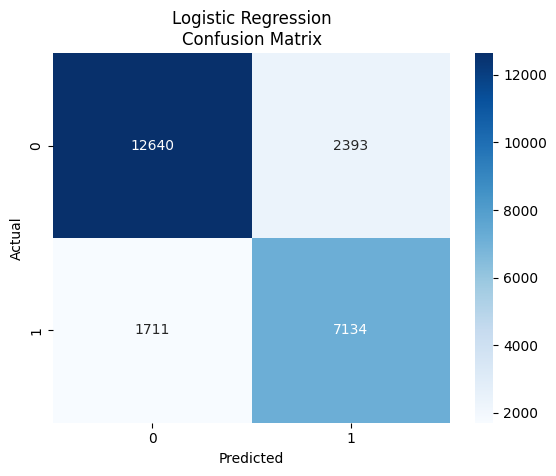

In [ ]:
# Logistic Regression Hyperparameter Tuning & Final Model Execution

def tune_logistic(X_train, y_train, n_trials=10, timeout=1800):
    """
    Tunes Logistic Regression hyperparameters using Optuna with ROC-AUC as the metric.
    Parameters:
        X_train: Training feature set
        y_train: Training labels
        n_trials: Number of Optuna trials
        timeout: Time limit for tuning in seconds
    Returns:
        study: Optuna study object with best parameters
    """
    # 5-fold Stratified CV for consistent splits
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    def objective(trial):
        """Objective function for Optuna hyperparameter optimization."""
        # Select penalty and solver
        penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet'])
        solver  = trial.suggest_categorical('solver',  ['liblinear', 'saga'])

        # Prune invalid penalty/solver combinations
        if penalty == 'elasticnet' and solver != 'saga':
            raise optuna.TrialPruned()
        if penalty == 'l1' and solver not in ['liblinear', 'saga']:
            raise optuna.TrialPruned()

        # Base hyperparameters
        params = {
            'C'            : trial.suggest_float('C', 1e-3, 1e2, log=True),       # Regularization strength
            'tol'          : trial.suggest_float('tol', 1e-4, 1e-2, log=True),    # Tolerance for stopping
            'penalty'      : penalty,
            'solver'       : solver,
            'class_weight' : trial.suggest_categorical('class_weight', [None, 'balanced']),
            'max_iter'     : trial.suggest_categorical('max_iter', [500, 1000, 2000]),
            'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
            'random_state' : 42,
        }

        # Set n_jobs for solvers that support parallelism (avoiding nested CV parallelism)
        if solver in ['saga', 'lbfgs', 'newton-cg', 'sag']:
            params['n_jobs'] = 1

        # ElasticNet penalty requires an l1_ratio
        if penalty == 'elasticnet':
            params['l1_ratio'] = trial.suggest_float('l1_ratio', 0.0, 1.0)

        # Create pipeline with preprocessing + classifier
        pipe = Pipeline([
            ('preprocessor', fresh_preprocessor()),
            ('clf', LogisticRegression(**params))
        ])

        # Cross-validation scoring
        scores = cross_val_score(pipe, X_train, y_train, cv=cv,
                                 scoring='roc_auc', n_jobs=-1)
        return scores.mean()

    # Create and run Optuna study
    study = optuna.create_study(
        direction='maximize',
        sampler=TPESampler(seed=42),
        pruner=MedianPruner(n_startup_trials=3, n_warmup_steps=0, interval_steps=1)
    )
    study.optimize(objective, n_trials=n_trials, timeout=timeout)

    print("Best LR hyper-parameters:", study.best_params)
    print(f"Best CV ROC-AUC: {study.best_value:.4f}")

    return study


def run_logistic(X_train, y_train, X_test, y_test, study=None):
    """
    Trains and evaluates the best Logistic Regression model from an Optuna study.
    Parameters:
        X_train, y_train: Training data
        X_test, y_test: Test data
        study: Pre-run Optuna study with best params
    Returns:
        best_pipe: Final trained model
        cv_summary: Cross-validation metrics
        holdout_summary: Holdout set metrics
    """
    # If no study passed, run tuning first
    if study is None:
        study = tune_logistic(X_train, y_train)

    # Retrieve best parameters and add consistent random_state
    best_params = {**study.best_params, 'random_state': 42}

    # Allow full core usage for final fit if solver supports it
    if best_params.get('solver') in ['saga', 'lbfgs', 'newton-cg', 'sag']:
        best_params['n_jobs'] = -1
    else:
        best_params.pop('n_jobs', None)

    # Build and fit the final model pipeline
    best_pipe = Pipeline([
        ('preprocessor', fresh_preprocessor()),
        ('clf', LogisticRegression(**best_params))
    ])
    best_pipe.fit(X_train, y_train)

    # Evaluate model
    cv_summary = cross_validate_metrics(best_pipe, X_train, y_train, cv_splits=5)
    holdout_summary = evaluate_holdout(best_pipe, X_test, y_test, 'Logistic Regression')

    return best_pipe, cv_summary, holdout_summary

# Run tuning and final model training
lr_study = tune_logistic(X_train, y_train)
best_lr, lr_cv, lr_holdout = run_logistic(X_train, y_train, X_test, y_test, lr_study)


**Random Forest**

[I 2025-08-28 19:29:09,767] A new study created in memory with name: no-name-12ee2907-e8c8-4f36-b044-7fa01bc2cea6
[I 2025-08-28 19:30:49,635] Trial 0 finished with value: 0.9470423641733421 and parameters: {'n_estimators': 151, 'max_depth': 24, 'min_samples_split': 15, 'min_samples_leaf': 12, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9470423641733421.
[I 2025-08-28 19:32:49,812] Trial 1 finished with value: 0.9436462510704133 and parameters: {'n_estimators': 193, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 20, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9470423641733421.
[I 2025-08-28 19:34:21,723] Trial 2 finished with value: 0.9467453520645469 and parameters: {'n_estimators': 139, 'max_depth': 16, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9470423641733421.
[I 2025-08-28 19:36:07,877] Trial 3 finished 

Best RF hyperparameters: {'n_estimators': 136, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 17, 'max_features': 0.5, 'class_weight': None}
Best CV ROC-AUC: 0.9485

Cross-validation metrics (5-fold):
 roc_auc: 0.9485 ± 0.0018
accuracy: 0.8742 ± 0.0019
precision: 0.8545 ± 0.0043
  recall: 0.7960 ± 0.0050
      f1: 0.8242 ± 0.0028
-- Test ROC-AUC (Random Forest): 0.9501
-- Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     15033
           1       0.86      0.80      0.83      8845

    accuracy                           0.88     23878
   macro avg       0.87      0.86      0.86     23878
weighted avg       0.87      0.88      0.87     23878



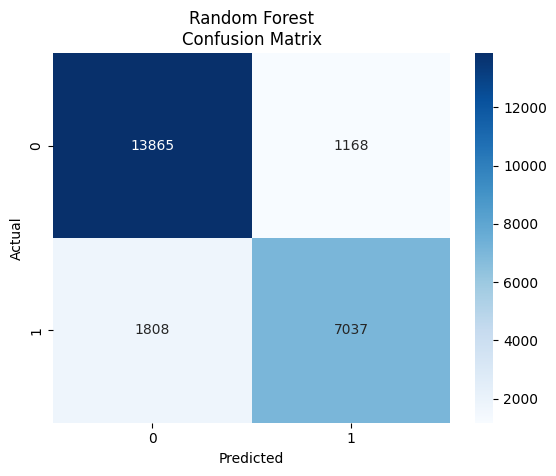

In [ ]:
# Random Forest Hyperparameter Tuning & Execution

def tune_random_forest(X_train, y_train, n_trials=10, timeout=2400):
    """
    Tunes Random Forest hyperparameters using Optuna with ROC-AUC scoring
    Parameters:
        X_train: Training features
        y_train: Training labels
        n_trials: Number of trials for Optuna search
        timeout: Time limit for tuning in seconds
    Returns:
        study: Optuna study object with best parameters
    """

    def objective(trial):
        """
        Defines the hyperparameter search space and returns
        the mean CV ROC-AUC score for a given trial.
        """
        # Hyperparameters
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 300, log=True),  # Number of trees
            'max_depth': trial.suggest_int('max_depth', 5, 25),                     # Max depth of each tree
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),     # Min samples to split
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),       # Min samples in leaf node
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 0.5]),  # Feature sampling strategy
            'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']) # Class balancing
        }

        # Build pipeline with preprocessing + classifier
        pipe = Pipeline([
            ('preprocessor', fresh_preprocessor()),
            ('clf', RandomForestClassifier(random_state=42, n_jobs=1, **params))  # n_jobs=1 avoids nested parallelism
        ])

        # 5-fold stratified CV
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        # Return mean ROC-AUC across folds
        return np.mean(cross_val_score(pipe, X_train, y_train, cv=cv,
                                       scoring='roc_auc', n_jobs=-1))

    # Create and run Optuna study
    study = optuna.create_study(
        direction='maximize',
        sampler=TPESampler(seed=42),
        pruner=MedianPruner(n_startup_trials=3, n_warmup_steps=0, interval_steps=1)
    )
    study.optimize(objective, n_trials=n_trials, timeout=timeout)

    print("Best RF hyperparameters:", study.best_params)
    print(f"Best CV ROC-AUC: {study.best_value:.4f}")

    return study

def run_random_forest(X_train, y_train, X_test, y_test, study=None):
    """
    Trains and evaluates the best Random Forest model from an Optuna study.
    Parameters:
        X_train, y_train: Training data
        X_test, y_test: Test data
        study: Pre-run Optuna study with best params
    Returns:
        pipe: Final trained model
        cv_summary: Cross-validation metrics
        holdout_summary: Holdout set metrics
    """
    # Prepare test data in the same feature format as training
    X_test_df = prepare_test_df(X_train, X_test)

    # If no tuning study provided, run it first
    if study is None:
        study = tune_random_forest(X_train, y_train)

    # Build final model pipeline with best parameters
    pipe = Pipeline([
        ('preprocessor', fresh_preprocessor()),
        ('clf', RandomForestClassifier(random_state=42, n_jobs=-1, **study.best_params))
    ])

    # Train model
    pipe.fit(X_train, y_train)

    # Evaluate performance on CV and holdout set
    cv_summary = cross_validate_metrics(pipe, X_train, y_train, cv_splits=5)
    holdout_summary = evaluate_holdout(pipe, X_test_df, y_test, 'Random Forest')

    return pipe, cv_summary, holdout_summary

# Run tuning and final model training
rf_study = tune_random_forest(X_train, y_train)
best_rf, rf_cv, rf_holdout = run_random_forest(X_train, y_train, X_test, y_test, rf_study)


**XGBoost**

In [ ]:
# XGBoost Hyperparameter Tuning & Execution

def tune_xgboost(X_train, y_train, imbalance_ratio, n_trials=10, timeout=1200):
    """
    Tunes XGBoost hyperparameters using Optuna with ROC-AUC as the metric
    Parameters:
        X_train: Training features
        y_train: Training labels
        imbalance_ratio: Ratio of negative to positive samples (for scale_pos_weight)
        n_trials: Number of Optuna trials
        timeout: Maximum tuning time in seconds
    Returns:
        study: Optuna study object containing best parameters
    """

    def objective(trial):
        """
        Defines the search space for XGBoost hyperparameters and evaluates
        via Stratified K-Fold cross-validation using ROC-AUC.
        """
        params = {
            # Core boosting parameters
            'n_estimators':      trial.suggest_int('n_estimators', 50, 300, log=True),   # boosting rounds
            'max_depth':         trial.suggest_int('max_depth', 3, 12),                  # Tree depth
            'learning_rate':     trial.suggest_float('learning_rate', 1e-3, 0.3, log=True), # Shrinkage rate
            'subsample':         trial.suggest_float('subsample', 0.5, 1.0),             # Row sampling
            'colsample_bytree':  trial.suggest_float('colsample_bytree', 0.5, 1.0),      # Feature sampling
            'gamma':             trial.suggest_float('gamma', 0.0, 5.0),                 # Minimum loss reduction
            'min_child_weight':  trial.suggest_int('min_child_weight', 1, 20),           # Minimum sum hessian in child
            'reg_alpha':         trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),  # L1 regularization
            'reg_lambda':        trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True), # L2 regularization

            # Handle imbalance
            'scale_pos_weight':  float(imbalance_ratio),  # Must be float for XGBoost

            # Speed optimizations
            'tree_method':       'hist'  # Histogram-based method for faster training
        }

        # Pipeline: preprocessing + classifier
        pipe = Pipeline([
            ('preprocessor', fresh_preprocessor()),
            ('xgb', XGBClassifier(
                eval_metric='auc',       # Matches scoring='roc_auc'
                verbosity=0,
                random_state=42,
                n_jobs=1,                # Avoid nested parallelism during CV
                **params
            ))
        ])

        # 5-fold stratified CV
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        # Return mean ROC-AUC score
        return np.mean(cross_val_score(pipe, X_train, y_train, cv=cv,
                                       scoring='roc_auc', n_jobs=-1))

    # Create and run Optuna study
    study = optuna.create_study(
        direction='maximize',
        sampler=TPESampler(seed=42),
        pruner=MedianPruner(n_startup_trials=3, n_warmup_steps=0, interval_steps=1)
    )
    study.optimize(objective, n_trials=n_trials, timeout=timeout)

    print("Best XGB hyperparameters:", study.best_params)
    print(f"Best CV ROC-AUC: {study.best_value:.4f}")

    return study

def run_xgboost(X_train, y_train, X_test, y_test, study=None):
    """
    Fits the final XGBoost model using the best Optuna parameters
    and evaluates performance on both CV and holdout sets.
    Parameters:
        X_train, y_train: Training data
        X_test, y_test: Test data
        study: Pre-run Optuna study
    Returns:
        pipe: Trained model pipeline
        cv_summary: Cross-validation metrics
        holdout_summary: Holdout metrics
    """
    # Ensure test set matches training feature structure
    X_test_df = prepare_test_df(X_train, X_test)

    # Compute imbalance ratio
    pos = np.sum(y_train == 1)
    neg = np.sum(y_train == 0)
    imb_ratio = float(neg) / float(pos)
    print(f"Imbalance ratio (neg/pos): {imb_ratio:.2f}")

    # If no study provided, perform tuning
    if study is None:
        study = tune_xgboost(X_train, y_train, imb_ratio)

    # Build pipeline with best parameters
    pipe = Pipeline([
        ('preprocessor', fresh_preprocessor()),
        ('xgb', XGBClassifier(
            eval_metric='auc',
            verbosity=0,
            random_state=42,
            n_jobs=-1,
            scale_pos_weight=imb_ratio,
            tree_method='hist',
            **study.best_params
        ))
    ])

    # Train final model
    pipe.fit(X_train, y_train)

    # Evaluate on CV and holdout set
    cv_summary = cross_validate_metrics(pipe, X_train, y_train, cv_splits=5)
    holdout_summary = evaluate_holdout(pipe, X_test_df, y_test, 'XGBoost')

    return pipe, cv_summary, holdout_summary

# Run tuning and final model training
imbalance_ratio = np.sum(y_train == 0) / np.sum(y_train == 1)
xgb_study = tune_xgboost(X_train, y_train, imbalance_ratio)
best_xgb, xgb_cv, xgb_holdout = run_xgboost(X_train, y_train, X_test, y_test, xgb_study)


[I 2025-08-28 19:59:58,896] A new study created in memory with name: no-name-0c511d93-6f71-498d-9eb3-0edb83bb3192
[I 2025-08-28 20:00:30,916] Trial 0 finished with value: 0.9549654834012185 and parameters: {'n_estimators': 97, 'max_depth': 12, 'learning_rate': 0.06504856968981275, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'min_child_weight': 2, 'reg_alpha': 0.08499808989182997, 'reg_lambda': 0.0006440507553993703}. Best is trial 0 with value: 0.9549654834012185.
[I 2025-08-28 20:00:48,521] Trial 1 finished with value: 0.942655550984186 and parameters: {'n_estimators': 177, 'max_depth': 3, 'learning_rate': 0.2526878207508456, 'subsample': 0.9162213204002109, 'colsample_bytree': 0.6061695553391381, 'gamma': 0.9091248360355031, 'min_child_weight': 4, 'reg_alpha': 2.716051144654844e-06, 'reg_lambda': 0.00015777981883364995}. Best is trial 0 with value: 0.9549654834012185.
[I 2025-08-28 20:01:05,056] Trial 2 finished with value: 0.

Best XGB hyperparameters: {'n_estimators': 97, 'max_depth': 12, 'learning_rate': 0.06504856968981275, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'min_child_weight': 2, 'reg_alpha': 0.08499808989182997, 'reg_lambda': 0.0006440507553993703}
Best CV ROC-AUC: 0.9550
Imbalance ratio (neg/pos): 1.70

Cross-validation metrics (5-fold):
 roc_auc: 0.9550 ± 0.0016
accuracy: 0.8784 ± 0.0025
precision: 0.8131 ± 0.0050
  recall: 0.8721 ± 0.0018
      f1: 0.8416 ± 0.0029
-- Test ROC-AUC (XGBoost): 0.9559
-- Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       0.92      0.88      0.90     15033
           1       0.82      0.88      0.84      8845

    accuracy                           0.88     23878
   macro avg       0.87      0.88      0.87     23878
weighted avg       0.88      0.88      0.88     23878



**LightGBM**

[I 2025-08-28 20:04:31,663] A new study created in memory with name: no-name-562ca559-b40b-4785-843b-e8828cae3ff6
/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[I 2025-08-28 20:05:04,995] Trial 0 finished with value: 0.9542812927561798 and parameters: {'n_estimators': 97, 'learning_rate': 0.22648248189516848, 'num_leaves': 115, 'max_depth': 10, 'min_child_samples': 19, 'subsample': 0.5779972601681014, 'colsample_bytree': 0.5290418060840998, 'reg_alpha': 0.08499808989182997, 'reg_lambda': 0.0006440507553993703}. Best is trial 0 with value: 0.9542812927561798.
[I 2025-08-28 20:05:48,167] Trial 1 finished with value: 0.9416678182775889 and parameters: {'n_estimators': 177, 'learning_rate': 0.001124579825911934, 'num_leaves': 147, 'max_depth': 13, 'min_child_samples': 25, 'subsample': 0.5909

Best LGBM hyperparameters: {'n_estimators': 97, 'learning_rate': 0.22648248189516848, 'num_leaves': 115, 'max_depth': 10, 'min_child_samples': 19, 'subsample': 0.5779972601681014, 'colsample_bytree': 0.5290418060840998, 'reg_alpha': 0.08499808989182997, 'reg_lambda': 0.0006440507553993703}
Best CV ROC-AUC: 0.9543

Cross-validation metrics (5-fold):
 roc_auc: 0.9543 ± 0.0014
accuracy: 0.8770 ± 0.0022
precision: 0.8112 ± 0.0038
  recall: 0.8705 ± 0.0032
      f1: 0.8398 ± 0.0028
-- Test ROC-AUC (LightGBM): 0.9556
-- Classification Report (LightGBM):
              precision    recall  f1-score   support

           0       0.92      0.88      0.90     15033
           1       0.81      0.88      0.84      8845

    accuracy                           0.88     23878
   macro avg       0.87      0.88      0.87     23878
weighted avg       0.88      0.88      0.88     23878



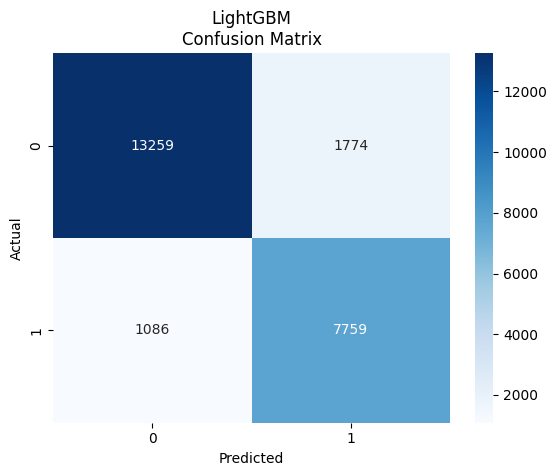

In [ ]:
# LightGBM Hyperparameter Tuning & Execution

# Suppress specific sklearn feature-name warning for LGBM
warnings.filterwarnings(
    "ignore",
    message="X does not have valid feature names, but LGBMClassifier was fitted with feature names"
)

def tune_lightgbm(X_train, y_train, n_trials=10, timeout=1200):
    """
    Tunes LightGBM hyperparameters using Optuna with ROC-AUC as the metric.
    Parameters:
        X_train: Training features
        y_train: Training labels
        n_trials: Number of Optuna trials
        timeout: Maximum tuning time in seconds
    Returns:
        study: Optuna study with best parameters
    """
    def objective(trial):
        """
        Defines the hyperparameter search space and evaluates
        performance using Stratified K-Fold CV and ROC-AUC.
        """
        params = {
            # Boosting & tree parameters
            'n_estimators':      trial.suggest_int('n_estimators', 50, 300, log=True),
            'learning_rate':     trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
            'num_leaves':        trial.suggest_int('num_leaves', 20, 150),
            'max_depth':         trial.suggest_int('max_depth', 3, 15),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            # Sampling parameters
            'subsample':         trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree':  trial.suggest_float('colsample_bytree', 0.5, 1.0),
            # Regularization
            'reg_alpha':         trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
            'reg_lambda':        trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True)
        }

        # Pipeline with preprocessing + LightGBM classifier
        pipe = Pipeline([
            ('preprocessor', fresh_preprocessor()),
            ('lgbm', LGBMClassifier(
                objective='binary',
                class_weight='balanced',   # Handles imbalance
                random_state=42,
                n_jobs=1,                  # Avoid nested parallelism during CV
                verbosity=-1,              # Suppress LightGBM logs
                **params
            ))
        ])

        # 5-fold stratified CV
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        # Return mean ROC-AUC score
        return np.mean(cross_val_score(pipe, X_train, y_train, cv=cv,
                                       scoring='roc_auc', n_jobs=-1))

    # Create and run Optuna study
    study = optuna.create_study(
        direction='maximize',
        sampler=TPESampler(seed=42),
        pruner=MedianPruner(n_startup_trials=3, n_warmup_steps=0, interval_steps=1)
    )
    study.optimize(objective, n_trials=n_trials, timeout=timeout)

    print("Best LGBM hyperparameters:", study.best_params)
    print(f"Best CV ROC-AUC: {study.best_value:.4f}")

    return study

def run_lightgbm(X_train, y_train, X_test, y_test, study=None):
    """
    Fits the final LightGBM model using the best Optuna parameters
    and evaluates performance on both CV and holdout sets.
    Parameters:
        X_train, y_train: Training data
        X_test, y_test: Test data
        study: Pre-run Optuna study
    Returns:
        pipe: Trained model pipeline
        cv_summary: Cross-validation metrics
        holdout_summary: Holdout metrics
    """
    # Convert test set to same feature structure as training set
    X_test_df = prepare_test_df(X_train, X_test)

    # If no Optuna study provided, run tuning first
    if study is None:
        study = tune_lightgbm(X_train, y_train)

    # Build pipeline with tuned parameters
    pipe = Pipeline([
        ('preprocessor', fresh_preprocessor()),
        ('lgbm', LGBMClassifier(
            objective='binary',
            class_weight='balanced',
            random_state=42,
            n_jobs=-1,                 # Full parallelism for final training
            verbosity=-1,              # Suppress LightGBM logs
            **study.best_params
        ))
    ])

    # Fit final model
    pipe.fit(X_train, y_train)

    # Cross-validation evaluation
    cv_summary = cross_validate_metrics(pipe, X_train, y_train, cv_splits=5)

    # Holdout set evaluation
    holdout_summary = evaluate_holdout(pipe, X_test_df, y_test, 'LightGBM')

    return pipe, cv_summary, holdout_summary

# Run tuning and final model training
lgb_study = tune_lightgbm(X_train, y_train)
best_lgb, lgb_cv, lgb_holdout = run_lightgbm(X_train, y_train, X_test, y_test, lgb_study)


**MLP Classifier**

[I 2025-08-28 20:14:28,503] A new study created in memory with name: no-name-d7ab9652-86a7-4d3c-ba95-93ce71b8c9a4
[I 2025-08-28 20:18:31,766] Trial 0 finished with value: 0.8643065280058877 and parameters: {'n_layers': 2, 'n_units_l0': 231, 'n_units_l1': 146, 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.002537815508265664, 'learning_rate_init': 0.006796578090758156, 'learning_rate': 'invscaling', 'validation_fraction': 0.08185086660174143, 'n_iter_no_change': 13, 'batch_size': 256, 'tol': 0.00019762189340280086, 'momentum': 0.2883168487960615}. Best is trial 0 with value: 0.8643065280058877.
[I 2025-08-28 20:22:07,443] Trial 1 finished with value: 0.32240089155061125 and parameters: {'n_layers': 2, 'n_units_l0': 42, 'n_units_l1': 58, 'activation': 'logistic', 'solver': 'sgd', 'alpha': 0.00234238498471129, 'learning_rate_init': 1.5339162591163613e-05, 'learning_rate': 'constant', 'validation_fraction': 0.192332830588, 'n_iter_no_change': 49, 'batch_size': 64, 'tol': 0.0011290133559

Best MLP hyperparameters: {'n_layers': 2, 'n_units_l0': 51, 'n_units_l1': 122, 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.00023134781612225627, 'learning_rate_init': 2.8437674894443664e-05, 'learning_rate': 'constant', 'validation_fraction': 0.14899760690512687, 'n_iter_no_change': 42, 'batch_size': 64, 'tol': 1.9024283247489577e-05}
Best CV ROC-AUC: 0.9391

Cross-validation metrics (5-fold):
 roc_auc: 0.9391 ± 0.0015
accuracy: 0.8555 ± 0.0032
precision: 0.7789 ± 0.0055
  recall: 0.8516 ± 0.0044
      f1: 0.8136 ± 0.0037
-- Test ROC-AUC (MLP Classifier): 0.9403
-- Classification Report (MLP Classifier):
              precision    recall  f1-score   support

           0       0.91      0.86      0.88     15033
           1       0.78      0.85      0.82      8845

    accuracy                           0.86     23878
   macro avg       0.85      0.86      0.85     23878
weighted avg       0.86      0.86      0.86     23878



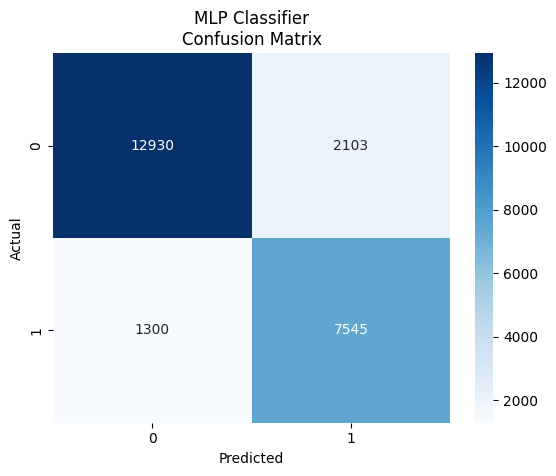

In [ ]:
# MLP Hyperparameter Tuning & Execution

def tune_mlp(X_train, y_train, n_trials=10, timeout=3600):
    """
    Tunes an MLPClassifier using Optuna.
    Includes tuning of:
        - hidden layer sizes
        - activation functions
        - solvers (adam, sgd)
        - learning rate strategy & init value
        - validation fraction for early stopping
        - momentum (if solver = sgd)
    Parameters:
        X_train: Training features
        y_train: Training labels
        n_trials: Number of Optuna trials
        timeout: Time limit for tuning in seconds
    Returns:
        study: Optuna study object with best parameters
    """

    def objective(trial):
        """Defines the hyperparameter search space and evaluation logic."""
        # Number of hidden layers and units per layer
        n_layers = trial.suggest_int('n_layers', 1, 3)
        hidden_units = tuple(
            trial.suggest_int(f'n_units_l{i}', 32, 256, log=True)
            for i in range(n_layers)
        )

        # Hyperparameters
        params = {
            'hidden_layer_sizes':  hidden_units,
            'activation':          trial.suggest_categorical('activation', ['relu', 'tanh', 'logistic']),
            'solver':              trial.suggest_categorical('solver', ['adam', 'sgd']),
            'alpha':               trial.suggest_float('alpha', 1e-5, 1e-1, log=True),  # L2 regularization
            'learning_rate_init':  trial.suggest_float('learning_rate_init', 1e-5, 1e-1, log=True),
            'learning_rate':       trial.suggest_categorical('learning_rate', ['constant', 'invscaling', 'adaptive']),
            'validation_fraction': trial.suggest_float('validation_fraction', 0.05, 0.2),
            'n_iter_no_change':    trial.suggest_int('n_iter_no_change', 5, 50),
            'batch_size':          trial.suggest_categorical('batch_size', [64, 128, 256]),
            'tol':                 trial.suggest_float('tol', 1e-5, 1e-2, log=True),
        }

        # Solver-specific hyperparameter
        if params['solver'] == 'sgd':
            params['momentum'] = trial.suggest_float('momentum', 0.0, 0.99)

        # Preprocessing + Oversampling + MLP
        pipe = ImbPipeline([
            ('preprocessor', fresh_preprocessor()),
            ('ros', RandomOverSampler(random_state=42)),
            ('mlp', MLPClassifier(
                **params,
                early_stopping=True,
                max_iter=1000,
                random_state=42
            ))
        ])

        # Stratified K-Fold CV with ROC-AUC
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_val_score(pipe, X_train, y_train, cv=cv,
                                 scoring='roc_auc', n_jobs=-1)

        return np.mean(scores)

    # Create and run Optuna study
    study = optuna.create_study(
        direction='maximize',
        sampler=TPESampler(seed=42),
        pruner=MedianPruner(n_startup_trials=3, n_warmup_steps=0, interval_steps=1)
    )
    study.optimize(objective, n_trials=n_trials, timeout=timeout)

    print("Best MLP hyperparameters:", study.best_params)
    print(f"Best CV ROC-AUC: {study.best_value:.4f}")

    return study

def run_mlp(X_train, y_train, X_test, y_test, study=None):
    """
    Fits the final MLP pipeline using the best Optuna parameters.
    Evaluates using both cross-validation and holdout testing.
    Parameters:
        X_train, y_train: Training data
        X_test, y_test: Test data
        study: Pre-run Optuna study
    Returns:
        pipe: Final trained pipeline
        cv_summary: Cross-validation metrics
        holdout_summary: Holdout metrics
    """

    # Prepare test dataset with same feature processing as train
    X_test_df = prepare_test_df(X_train, X_test)

    # Run tuning if no study provided
    if study is None:
        study = tune_mlp(X_train, y_train)

    # Extract tuned parameters & rebuild hidden_layer_sizes
    bp = study.best_params.copy()
    n_layers = bp.pop('n_layers')
    hidden_units = tuple(bp.pop(f'n_units_l{i}') for i in range(n_layers))

    # Final pipeline with tuned params
    pipe = ImbPipeline([
        ('preprocessor', fresh_preprocessor()),
        ('ros', RandomOverSampler(random_state=42)),
        ('mlp', MLPClassifier(
            hidden_layer_sizes=hidden_units,
            **bp,
            early_stopping=True,
            max_iter=1000,
            random_state=42
        ))
    ])

    # Fit model & evaluate
    pipe.fit(X_train, y_train)
    cv_summary = cross_validate_metrics(pipe, X_train, y_train, cv_splits=5)
    holdout_summary = evaluate_holdout(pipe, X_test_df, y_test, 'MLP Classifier')

    return pipe, cv_summary, holdout_summary

# Run tuning and final model training
mlp_study = tune_mlp(X_train, y_train)
best_mlp, mlp_cv, mlp_holdout = run_mlp(X_train, y_train, X_test, y_test, mlp_study)


**Results Registry: Save/Load Trained Pipelines & Metrics (CV + Holdout)**

In [ ]:
# ---------------------------------------------------------------------------------
# USER TOGGLE

# Setting True, expects best_lr, best_rf, etc. defined in memory, will overwrite files.
# Setting False, skips to loading whatever is on disk.

# To load from disk, create a directory 'model_results'
# and load each model's joblib files

REFRESH_RESULTS = True
# ---------------------------------------------------------------------------------

RESULTS_DIR = Path('model_results')
RESULTS_DIR.mkdir(exist_ok=True)

if REFRESH_RESULTS:
    # Should have already run the models to get these five tuples:
    #     best_lr, lr_cv, lr_holdout  = run_logistic(...)
    #     best_rf, rf_cv, rf_holdout  = run_random_forest(...)
    #     best_xgb, xgb_cv, xgb_holdout = run_xgboost(...)
    #     best_lgb, lgb_cv, lgb_holdout = run_lightgbm(...)
    #     best_mlp, mlp_cv, mlp_holdout = run_mlp(...)
    #
    # Build the dict in memory and overwrite the .joblib files
    model_results = {
        'Logistic Regression': {
            'pipeline': best_lr,
            'cv': lr_cv,
            'holdout': lr_holdout
        },
        'Random Forest': {
            'pipeline': best_rf,
            'cv': rf_cv,
            'holdout': rf_holdout
        },
        'XGBoost': {
            'pipeline': best_xgb,
            'cv': xgb_cv,
            'holdout': xgb_holdout
        },
        'LightGBM': {
            'pipeline': best_lgb,
            'cv': lgb_cv,
            'holdout': lgb_holdout
        },
        'MLP Classifier': {
            'pipeline': best_mlp,
            'cv': mlp_cv,
            'holdout': mlp_holdout
        },
        'Dummy Classifier': {
            'pipeline': dummy_pipe,
            'cv': dummy_cv,
            'holdout': dummy_holdout
        }
    }

    for name, results in model_results.items():
        path = RESULTS_DIR / f"{name.replace(' ', '_').lower()}_results.joblib"
        joblib.dump(results, path)
        print(f"Overwrite results for '{name}' → {path}")

else:
    # Load from disk
    model_results = {}
    for path in RESULTS_DIR.glob('*_results.joblib'):
        name = path.stem.replace('_results','').replace('_',' ').title()
        model_results[name] = joblib.load(path)
        print(f"Loaded results for '{name}' from {path}")

Overwrite results for 'Logistic Regression' → model_results/logistic_regression_results.joblib
Overwrite results for 'Random Forest' → model_results/random_forest_results.joblib
Overwrite results for 'XGBoost' → model_results/xgboost_results.joblib
Overwrite results for 'LightGBM' → model_results/lightgbm_results.joblib
Overwrite results for 'MLP Classifier' → model_results/mlp_classifier_results.joblib
Overwrite results for 'Dummy Classifier' → model_results/dummy_classifier_results.joblib


In [ ]:
# Build summaries & plots from model_results

# Wrap test set
X_test_df = prepare_test_df(X_train, X_test)

# 5-fold CV summary
cv_rows = []
for name, res in model_results.items():
    cv = res['cv']
    cv_rows.append({
        'Model'    : name,
        'ROC-AUC'  : cv.get('ROC_AUC'),
        'Accuracy' : cv.get('ACCURACY'),
        'Precision': cv.get('PRECISION'),
        'Recall'   : cv.get('RECALL'),
        'F1 Score' : cv.get('F1 Score'),
    })

df_cv = (
    pd.DataFrame(cv_rows)
      .set_index('Model')
      [['ROC-AUC','Accuracy','Precision','Recall','F1 Score']]
)
print("--- 5-fold CV(mean ± std) ---")
display(df_cv)

# Single hold-out summary
holdout_rows = []
for name, res in model_results.items():
    h = res['holdout']
    holdout_rows.append({
        'Model'    : name,
        'ROC-AUC'  : h['ROC-AUC'],
        'Accuracy' : h['Accuracy'],
        'Precision': h['Precision'],
        'Recall'   : h['Recall'],
        'F1 Score' : h['F1 Score'],
    })

df_holdout = (
    pd.DataFrame(holdout_rows)
      .set_index('Model')
      [['ROC-AUC','Accuracy','Precision','Recall','F1 Score']]
)
print("\n\n--- Single hold-out metrics ---")
display(df_holdout)

--- 5-fold CV(mean ± std) ---


ROC-AUC         Accuracy        Precision           Recall         F1 Score
Model                                                                                                   
Logistic Regression  0.9122 ± 0.0018  0.8284 ± 0.0017  0.7471 ± 0.0030  0.8114 ± 0.0053  0.7779 ± 0.0024
Random Forest        0.9485 ± 0.0018  0.8742 ± 0.0019  0.8545 ± 0.0043  0.7960 ± 0.0050  0.8242 ± 0.0028
XGBoost              0.9550 ± 0.0016  0.8784 ± 0.0025  0.8131 ± 0.0050  0.8721 ± 0.0018  0.8416 ± 0.0029
LightGBM             0.9543 ± 0.0014  0.8770 ± 0.0022  0.8112 ± 0.0038  0.8705 ± 0.0032  0.8398 ± 0.0028
MLP Classifier       0.9391 ± 0.0015  0.8555 ± 0.0032  0.7789 ± 0.0055  0.8516 ± 0.0044  0.8136 ± 0.0037
Dummy Classifier     0.4979 ± 0.0030  0.5324 ± 0.0028  0.3677 ± 0.0038  0.3645 ± 0.0038  0.3661 ± 0.0038



--- Single hold-out metrics ---


ROC-AUC Accuracy Precision  Recall F1 Score
Model                                                          
Logistic Regression  0.9106   0.8281    0.7488  0.8066   0.7766
Random Forest        0.9501   0.8754    0.8576  0.7956   0.8255
XGBoost              0.9559   0.8807    0.8157  0.8759   0.8447
LightGBM             0.9556   0.8802    0.8139  0.8772   0.8444
MLP Classifier       0.9403   0.8575    0.7820  0.8530   0.8160
Dummy Classifier     0.5028   0.5360    0.3739  0.3746   0.3742

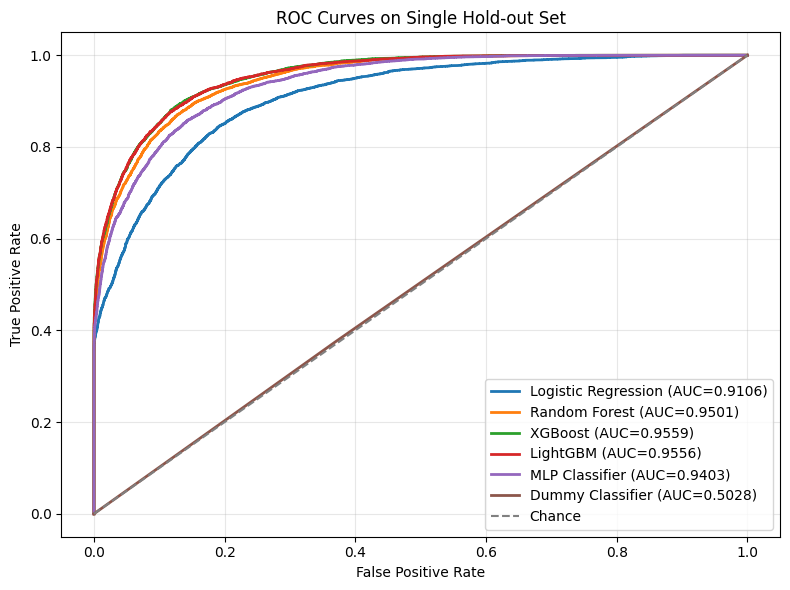

In [ ]:
# ROC-AUC Curves

# ROC curves on single hold-out set
plt.figure(figsize=(8,6))
for name, res in model_results.items():
    mdl = res['pipeline']
    if hasattr(mdl, 'predict_proba'):
        y_score = mdl.predict_proba(X_test_df)[:,1]
    else:
        raw = mdl.decision_function(X_test_df)
        y_score = (raw - raw.min())/(raw.max()-raw.min())
    fpr, tpr, _ = roc_curve(y_test, y_score)
    auc_val = float(res['holdout']['ROC-AUC'])
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC={auc_val:.4f})")

plt.plot([0,1],[0,1], linestyle='--', color='gray', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves on Single Hold-out Set')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


**Single Hold-out Evaluation, Model Comparison & Champion Selection**

In [ ]:
# Single Hold-out Evaluation, Model Comparison & Champion Selection

# Build X_test_df
X_test_df = prepare_test_df(X_train, X_test)

# Re-compute single hold-out metrics for each stored pipeline
holdout_rows = []
probas = {}

for name, res in model_results.items():
    mdl = res['pipeline'] # exact fitted Pipeline

    # get probabilities and preds
    y_prob = mdl.predict_proba(X_test_df)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)

    # compute metrics
    auc_v = roc_auc_score(y_test, y_prob)
    acc_v = accuracy_score(y_test, y_pred)
    prec_v = precision_score(y_test, y_pred)
    rec_v = recall_score(y_test, y_pred)
    f1_v = f1_score(y_test, y_pred)

    holdout_rows.append({
        'Model'    : name,
        'ROC-AUC'  : f"{auc_v:.4f}",
        'Accuracy' : f"{acc_v:.4f}",
        'Precision': f"{prec_v:.4f}",
        'Recall'   : f"{rec_v:.4f}",
        'F1 Score' : f"{f1_v:.4f}"
    })
    probas[name] = y_prob

df_holdout = (
    pd.DataFrame(holdout_rows)
      .set_index('Model')
      [['ROC-AUC','Accuracy','Precision','Recall','F1 Score']]
)

print("--- Single hold-out metrics (recomputed) ---")
display(df_holdout)

# Champion selection by ROC-AUC and by F1
roc_vals = df_holdout['ROC-AUC'].astype(float)
f1_vals = df_holdout['F1 Score'].astype(float)

champ_auc_name = roc_vals.idxmax()
champ_auc_val = roc_vals.max()

champ_f1_name = f1_vals.idxmax()
champ_f1_val = f1_vals.max()

print(f"\nChampion by ROC-AUC: {champ_auc_name} (AUC = {champ_auc_val:.4f})")
print(f"Champion by F1: {champ_f1_name} (F1  = {champ_f1_val:.4f})")

# For the ROC-AUC champion, find optimal F1 threshold
champ = champ_auc_name
y_prob_ch = probas[champ]

precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob_ch)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_idx = np.nanargmax(f1_scores[:-1])
best_thresh = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"\nOptimal threshold for {champ} (max F1 = {best_f1:.4f}): {best_thresh:.4f}")
y_pred_best = (y_prob_ch >= best_thresh).astype(int)

print(f"\nClassification Report for {champ} at threshold {best_thresh:.2f}:")
print(classification_report(y_test, y_pred_best))

--- Single hold-out metrics (recomputed) ---


ROC-AUC Accuracy Precision  Recall F1 Score
Model                                                          
Logistic Regression  0.9106   0.8281    0.7488  0.8066   0.7766
Random Forest        0.9501   0.8754    0.8576  0.7956   0.8255
XGBoost              0.9559   0.8807    0.8157  0.8759   0.8447
LightGBM             0.9556   0.8802    0.8139  0.8772   0.8444
MLP Classifier       0.9403   0.8575    0.7820  0.8530   0.8160
Dummy Classifier     0.5028   0.5360    0.3739  0.3746   0.3742


Champion by ROC-AUC: XGBoost (AUC = 0.9559)
Champion by F1: XGBoost (F1  = 0.8447)

Optimal threshold for XGBoost (max F1 = 0.8463): 0.4948

Classification Report for XGBoost at threshold 0.49:
              precision    recall  f1-score   support

           0       0.93      0.88      0.90     15033
           1       0.82      0.88      0.85      8845

    accuracy                           0.88     23878
   macro avg       0.87      0.88      0.87     23878
weighted avg       0.88      0.88      0.88     23878



In [ ]:
# Save the champion model and load

CHAMPION_NAME = 'XGBoost'
CHAMPION_THRESH = 0.4948
joblib.dump({'model': best_xgb,
             'threshold': CHAMPION_THRESH},
            'champion_xgb.joblib')


['champion_xgb.joblib']

**Calibration Check**

In [ ]:
# Calibration Check, Overfitting Guard & Final Champion by F1

# Ensure the raw champion & threshold is in memory
try:
    champ_raw = best_xgb
    best_thresh
    print("Using in-memory best_xgb and threshold")
except NameError:
    print("Loading saved champion from disk...")
    data = joblib.load('champion_xgb.joblib')
    champ_raw = data['model']
    best_thresh = data['threshold']

# Fit calibrators on training set
cal_sig = CalibratedClassifierCV(
    estimator=clone(champ_raw),
    method='sigmoid', cv=5, n_jobs=-1
).fit(X_train, y_train)

cal_iso = CalibratedClassifierCV(
    estimator=clone(champ_raw),
    method='isotonic', cv=5, n_jobs=-1
).fit(X_train, y_train)

candidates = {
    'Raw XGB'      : champ_raw,
    'Sigmoid-cal'  : cal_sig,
    'Isotonic-cal' : cal_iso
}

# Helper to compute expected calibration error (ECE)
def compute_ece(y_true, y_prob, n_bins=10):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    inds = np.digitize(y_prob, bins[1:-1])
    ece_val = 0.0
    for i in range(n_bins):
        mask = inds == i
        if not mask.any():
            continue
        ece_val += mask.mean() * abs(y_true[mask].mean() - y_prob[mask].mean())
    return ece_val

# Compute calibration & discrimination on both train and hold-out, then plot reliability curves
records = []
plt.figure(figsize=(6, 6))

for name, mdl in candidates.items():
    # train-set probabilities & ECE
    y_prob_train = mdl.predict_proba(X_train)[:, 1]
    train_ece = compute_ece(y_train, y_prob_train)

    # hold-out probabilities & metrics
    y_prob_test = mdl.predict_proba(X_test_df)[:, 1]
    hold_ece = compute_ece(y_test, y_prob_test)
    brier = brier_score_loss(y_test, y_prob_test)
    auc = roc_auc_score(y_test, y_prob_test)

    # use the same previous threshold for F1 comparison
    y_pred_test = (y_prob_test >= best_thresh).astype(int)
    hold_f1 = f1_score(y_test, y_pred_test)

    # reliability for plot
    frac_pos, mean_prob = calibration_curve(y_test, y_prob_test, n_bins=10)
    plt.plot(mean_prob, frac_pos, marker='o', label=name)

    records.append({
        'Model'      : name,
        'train_ECE'  : train_ece,
        'hold_ECE'   : hold_ece,
        'Brier'      : brier,
        'ROC-AUC'    : auc,
        'F1@orig_thr': hold_f1
    })

# plot perfect-calibration line
plt.plot([0, 1], [0, 1], '--', color='gray', label='Perfect Cal.')
plt.title('Reliability Diagram – All Variants')
plt.xlabel('Predicted probability')
plt.ylabel('True fraction of positives')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Build DataFrame & detect over-fitting
df_cal = (pd.DataFrame(records)
            .set_index('Model')
          )

# flag over-fitting: train ECE much lower than hold-out ECE (e.g. < 80%)
df_cal['overfit'] = df_cal['train_ECE'] < 0.8 * df_cal['hold_ECE']

display(df_cal.style
        .format({'train_ECE'  : '{:.4f}',
                 'hold_ECE'   : '{:.4f}',
                 'Brier'      : '{:.4f}',
                 'ROC-AUC'    : '{:.4f}',
                 'F1@orig_thr': '{:.4f}'})
        .set_caption("Calibration & Discrimination Metrics"))

# Select final champion by calibration (lowest hold_ECE among non-overfit)
survivors = df_cal[~df_cal['overfit']].copy()
if survivors.empty:
    print("All variants flagged as over-fit, using all for selection.")
    survivors = df_cal

winner = survivors['hold_ECE'].idxmin()
print(f"\nChampion by calibration: {winner} "
      f"(hold-out ECE={survivors.loc[winner,'hold_ECE']:.4f})")

# (Re-)optimise classification threshold for the winner on hold-out
y_prob_win = candidates[winner].predict_proba(X_test_df)[:, 1]
prec, rec, thr_vals = precision_recall_curve(y_test, y_prob_win)
f1_vals = 2 * prec * rec / (prec + rec)
best_i = np.nanargmax(f1_vals[:-1])
opt_thresh = thr_vals[best_i]
opt_f1 = f1_vals[best_i]
print(f"Optimal F1 for {winner} = {opt_f1:.4f} at thresh = {opt_thresh:.3f}")

# Persist the final calibrated champion + its threshold
final_artifact = {
    'model': candidates[winner],
    'threshold': opt_thresh
}


Using in-memory best_xgb and threshold



Champion by calibration: Isotonic-cal (hold-out ECE=0.0052)
Optimal F1 for Isotonic-cal = 0.8454 at thresh = 0.349


**Risk-Bucket Analysis with Decile Cut-Points**

Decile probability cut-points:
0.0    0.000
0.1    0.000
0.2    0.003
0.3    0.018
0.4    0.078
0.5    0.192
0.6    0.378
0.7    0.629
0.8    0.875
0.9    1.000
1.0    1.000

Threshold 0.349 falls into risk bucket 5


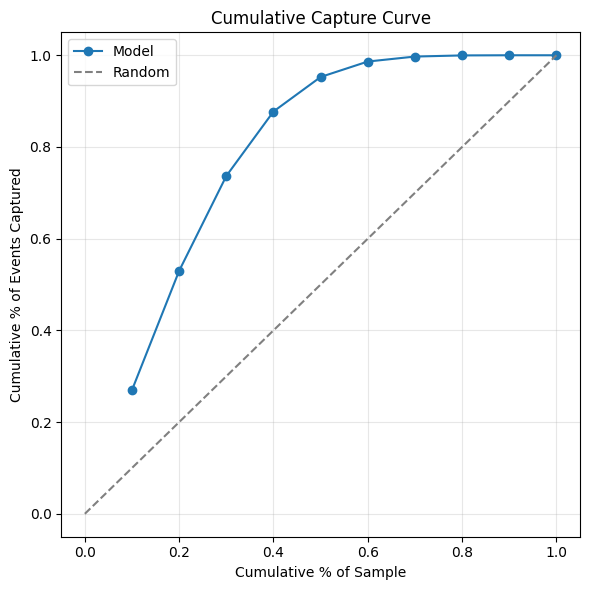

In [ ]:
# Risk-Bucket Analysis with Decile Cut-Points & Threshold Mapping

# Final model and threshold from the artifact
try:
    final_artifact
except NameError:
    raise RuntimeError("final_artifact not found, please run Section 12 first")

final_model = final_artifact['model']
final_thresh = final_artifact['threshold']

# Build DataFrame of true labels + predicted probabilities
df_rb = pd.DataFrame({
    'y_true': y_test,
    'y_prob': final_model.predict_proba(X_test_df)[:, 1]
})

# Compute & print the probability-based decile cut-points
prob_cut = df_rb['y_prob'].quantile(np.linspace(0, 1, 11))
print("Decile probability cut-points:")
print(prob_cut.round(3).to_string())

# Assign equal-sized deciles to risk_bucket
ranks = df_rb['y_prob'].rank(method='first')
df_rb['decile'] = pd.qcut(ranks, 10, labels=False) + 1  # 1...10
df_rb['risk_bucket'] = 11 - df_rb['decile']             # 1 = highest risk

# Determine which bucket the chosen threshold falls into

# Find the decile index by seeing which prob_cut interval contains final_thresh
# prob_cut has 11 values from 0% to 100% quantile
edges = prob_cut.values
dec_idx = np.searchsorted(edges, final_thresh, side='right') - 1
dec_idx = np.clip(dec_idx, 0, 9)   # ensure in [0...9]
bucket_of_thresh = 10 - dec_idx    # because bucket = 11 - decile
print(f"\nThreshold {final_thresh:.3f} falls into risk bucket {bucket_of_thresh}")

# Aggregate per bucket
overall_rate = df_rb['y_true'].mean()
agg = (
    df_rb
      .groupby('risk_bucket')
      .agg(
          total_samples = ('y_true','count'),
          total_events  = ('y_true','sum')
      )
      .sort_index()
      .reset_index()
)
agg['event_rate'] = agg['total_events'] / agg['total_samples']
agg['lift'] = agg['event_rate'] / overall_rate

# Display the risk-bucket table
display(
    agg.style
       .format({'event_rate': '{:.2%}', 'lift': '{:.2f}'})
       .set_caption("Equal-Sized Risk Buckets (1 = Highest Risk)")
)

# Event-rate bar chart
plt.figure(figsize=(8,4))
plt.bar(agg['risk_bucket'].astype(str), agg['event_rate'])
plt.axhline(overall_rate, linestyle='--', color='gray',
            label=f'Overall rate ({overall_rate:.2%})')
plt.xlabel('Risk Bucket (1 = Highest Risk)')
plt.ylabel('Event Rate')
plt.title('Event Rate by Risk Bucket')
plt.legend()
plt.tight_layout()
plt.show()

# Cumulative capture curve
agg['cum_events'] = agg['total_events'].cumsum()
agg['cum_sample_share'] = agg['total_samples'].cumsum() / agg['total_samples'].sum()
agg['cum_event_share'] = agg['cum_events'] / agg['total_events'].sum()

plt.figure(figsize=(6,6))
plt.plot(agg['cum_sample_share'], agg['cum_event_share'],
         marker='o', label='Model')
plt.plot([0,1], [0,1], '--', color='gray', label='Random')
plt.xlabel('Cumulative % of Sample')
plt.ylabel('Cumulative % of Events Captured')
plt.title('Cumulative Capture Curve')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


**SHAP-based Feature-level Interpretability**

In [ ]:
# SHAP-based Feature-level Interpretability

# Load fitted raw-XGB pipeline
try:
    champ_raw
except NameError:
    champ_raw = joblib.load("champion_xgb.joblib")["model"]

pre = champ_raw.named_steps["preprocessor"]
xgb_model = champ_raw.named_steps["xgb"]
feat_names = pre.get_feature_names_out()

# Build background & SHAP samples for speed-vs-fidelity
X_bg = pre.transform(X_train.sample(n=min(1_000, len(X_train)),
                                          random_state=42))
X_test_tr = pre.transform(X_test_df)

# Use the FULL test set for SHAP (no downsampling)
n_shap = X_test_tr.shape[0]
idx = np.arange(X_test_tr.shape[0])
X_shap = X_test_tr[idx]

# Instantiate TreeExplainer on probability output
explainer = shap.Explainer(
    xgb_model, X_bg,
    feature_names=feat_names,
    model_output="probability"
)
sh_exp = explainer(X_shap) # Explanation object

# Extract positive-class SHAP matrix (robust to 2D or 3D)
values = sh_exp.values # (n, p)  or  (n, 2, p)
if values.ndim == 3:   # multi-output
    shap_mat = values[:, 1, :]  # class-1 slice
    base_val = sh_exp.base_values[:, 1] if sh_exp.base_values.ndim == 2 \
               else sh_exp.base_values[1]
else: # already (n, p)
    shap_mat, base_val = values, sh_exp.base_values

# Build new Explanation strictly for class-1
exp_pos = shap.Explanation(
    values       = shap_mat,
    base_values  = base_val,
    data         = X_shap,
    feature_names= feat_names
)


100%|===================| 23860/23878 [10:35<00:00]       

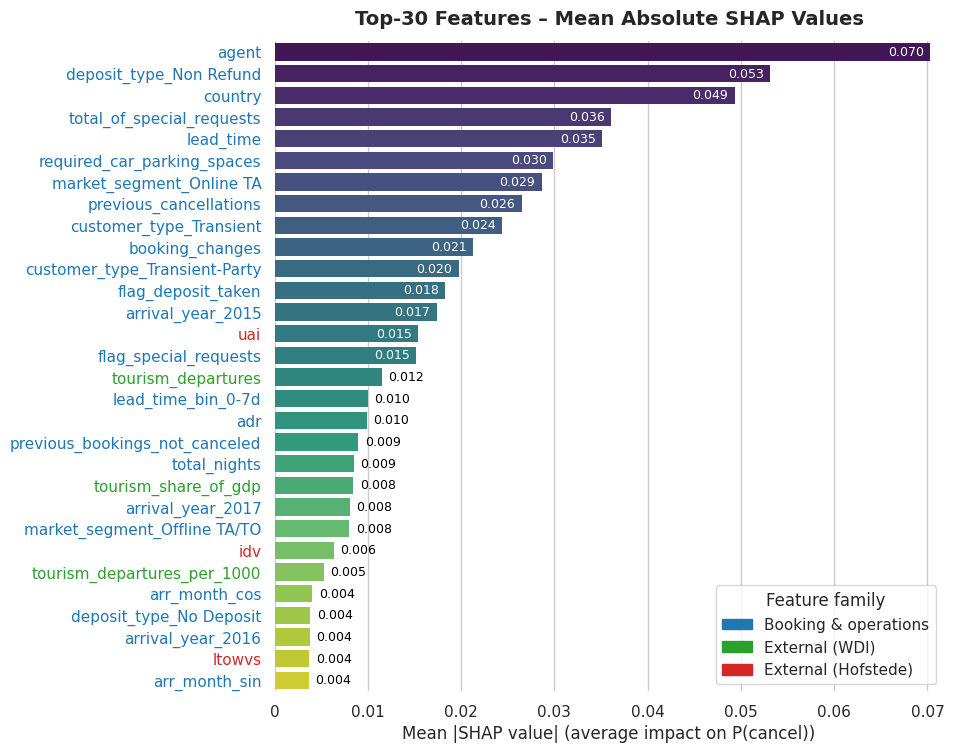

In [ ]:
# Mean |SHAP| bar-plot

# Prepare the data
mean_abs = np.abs(shap_mat).mean(axis=0)  # mean(|SHAP|) for every feature
top_k = 30
top_idx = np.argsort(mean_abs)[-top_k:][::-1]

feat_top = np.array(feat_names)[top_idx]
feat_wrapped = [textwrap.fill(f, width=32) for f in feat_top]

df = pd.DataFrame({
    "feature": feat_top,
    "feature_wrapped": feat_wrapped,
    "mean_abs_shap": mean_abs[top_idx]
})

# Minimal family mapping
LOW_CARD = set(low_card_feats) if 'low_card_feats' in globals() else set()

def _base_feature(name: str) -> str:
    core = name.split(' = ')[0]
    core = core.split('__')[-1]  # strip ColumnTransformer prefixes
    for col in LOW_CARD:         # collapse OHE levels back to base column
        if core.startswith(f"{col}_"):
            return col
    return core

def _feature_group(base: str) -> str:
    g = FEATURE_META.get(base, {}).get('group', '')
    if g.startswith('H ·'):  # External (WDI)
        return 'External (WDI)'
    if g.startswith('I ·'):  # External (Hofstede)
        return 'External (Hofstede)'
    return 'Booking & operations'

feat_to_bucket = {f: _feature_group(_base_feature(f)) for f in feat_names}

BUCKET_COLORS = {
    'Booking & operations': '#1f77b4',   # blue
    'External (WDI)' : '#2ca02c',        # green
    'External (Hofstede)' : '#d62728',   # red
}

df['bucket'] = df['feature'].map(lambda f: feat_to_bucket.get(f, 'Booking & operations'))

# Plot
sns.set_theme(context="notebook", style="whitegrid")
cmap = sns.color_palette("viridis", n_colors=top_k)

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(
    data=df,
    y="feature_wrapped",
    x="mean_abs_shap",
    hue="feature",
    palette=cmap,
    dodge=False,
    legend=False,
    edgecolor="none",
    ax=ax
)

# Value annotations
xmax = df["mean_abs_shap"].max()
for p in ax.patches:
    w = p.get_width()
    y = p.get_y() + p.get_height()/2
    label = f"{w:.3f}"
    if w >= 0.18 * xmax:
        ax.text(w - 0.01*xmax, y, label, va="center", ha="right", fontsize=9, color="white")
    else:
        ax.text(w + 0.01*xmax, y, label, va="center", ha="left", fontsize=9, color="black")

ax.set_xlabel("Mean |SHAP value| (average impact on P(cancel))", fontsize=12)
ax.set_ylabel("")
ax.set_title(f"Top-{top_k} Features – Mean Absolute SHAP Values",
             fontsize=14, weight="bold", pad=12)
ax.margins(x=0.02)
ax.xaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"{v:.3f}".rstrip('0').rstrip('.')))
sns.despine(left=True, bottom=True)

# Color y-tick labels by family
for tick in ax.get_yticklabels():
    wrapped = tick.get_text()
    bucket_series = df.loc[df['feature_wrapped'] == wrapped, 'bucket']
    fam = bucket_series.iloc[0] if not bucket_series.empty else 'Booking & operations'
    tick.set_color(BUCKET_COLORS.get(fam, '#333333'))

# Legend explaining label colors
handles = [Patch(color=c, label=k) for k, c in BUCKET_COLORS.items()]
ax.legend(handles=handles, title='Feature family', loc='lower right', frameon=True)

fig.tight_layout(pad=2)
plt.show()


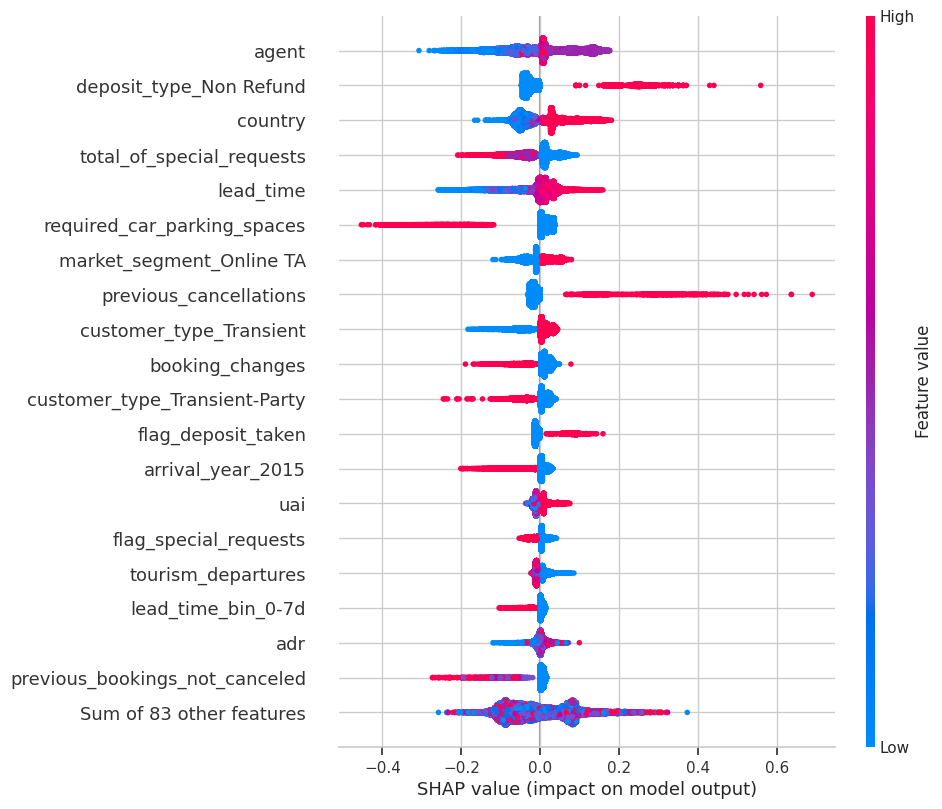

<Figure size 640x480 with 0 Axes>

In [ ]:
# Beeswarm – SHAP value distribution
plt.figure(figsize=(10, 6))
shap.plots.beeswarm(exp_pos, max_display=20)
plt.tight_layout()
plt.show()

In [ ]:
# SHAP heat-map
sns.set_theme(context="notebook", style="white")

# Instance ordering
inst_order = np.argsort(np.abs(exp_pos.values).sum(1))[::-1]

# render the heat-map
ax = shap.plots.heatmap(
        exp_pos,
        max_display=20,
        instance_order=inst_order,
        show=False
     )
fig = plt.gcf()
fig.set_size_inches(12, 7)
fig.tight_layout(pad=2.0)

# Title & axis labels
ax.set_title("SHAP heat-map (top-20 features)",
             fontsize=14, weight="bold", pad=14)
ax.set_xlabel("Features, ranked by mean |SHAP|", fontsize=12)
ax.set_ylabel("Test instances (overall impact ↓)", fontsize=12)

# Rotate x-tick labels for readability
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# pick up the first AxesImage
im = ax.images[0]
cbar = fig.colorbar(im,
                    ax=ax,
                    orientation="horizontal",
                    fraction=0.045,
                    pad=0.08)
cbar.set_label("SHAP value", fontsize=11)
cbar.ax.tick_params(labelsize=10)

sns.despine(fig, offset=8)
plt.show()


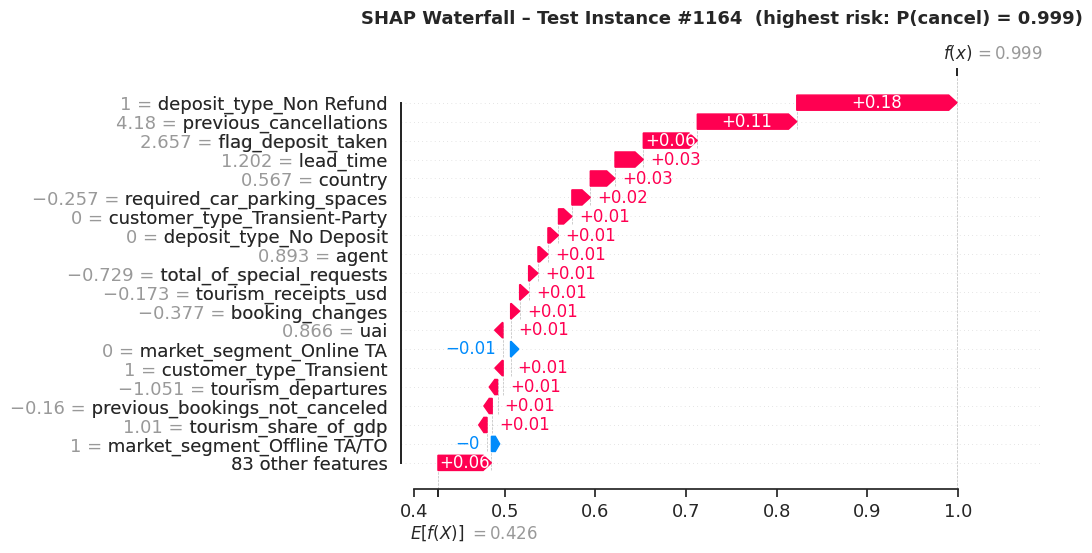

In [ ]:
# Waterfall for single highest-risk booking
sns.set_theme(context="notebook", style="white")

# Find the highest-risk test instance
probs_all = champ_raw.predict_proba(X_test_df)
idx_hi = int(np.argmax(probs_all[:, 1]))
p_hi = float(probs_all[idx_hi, 1])

# Transform and explain that single instance
x_hi_tr = pre.transform(X_test_df.iloc[[idx_hi]])
sh_hi = explainer(x_hi_tr)

# Robust extraction for binary / multi-output SHAP
if sh_hi.values.ndim == 3:
    hi_vals = sh_hi.values[0, 1, :]
    hi_base = sh_hi.base_values[0, 1] if sh_hi.base_values.ndim == 2 else sh_hi.base_values[1]
else:
    hi_vals = sh_hi.values[0]
    hi_base = sh_hi.base_values[0] if np.ndim(sh_hi.base_values) else sh_hi.base_values

# Build Explanation strictly for class-1
exp_hi = shap.Explanation(values=hi_vals,
                          base_values=hi_base,
                          data=x_hi_tr[0],
                          feature_names=feat_names)

# Waterfall
ax = shap.plots.waterfall(exp_hi, max_display=20, show=False)

fig = plt.gcf()
fig.set_size_inches(11, 6)
ax.set_title(
    f"SHAP Waterfall – Test Instance #{idx_hi}  (highest risk: P(cancel) = {p_hi:.3f})",
    pad=14, fontsize=13, weight="bold"
)
sns.despine(fig=fig, trim=True)
fig.tight_layout(pad=2)
plt.show()


**Partial-Dependence & ICE**

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


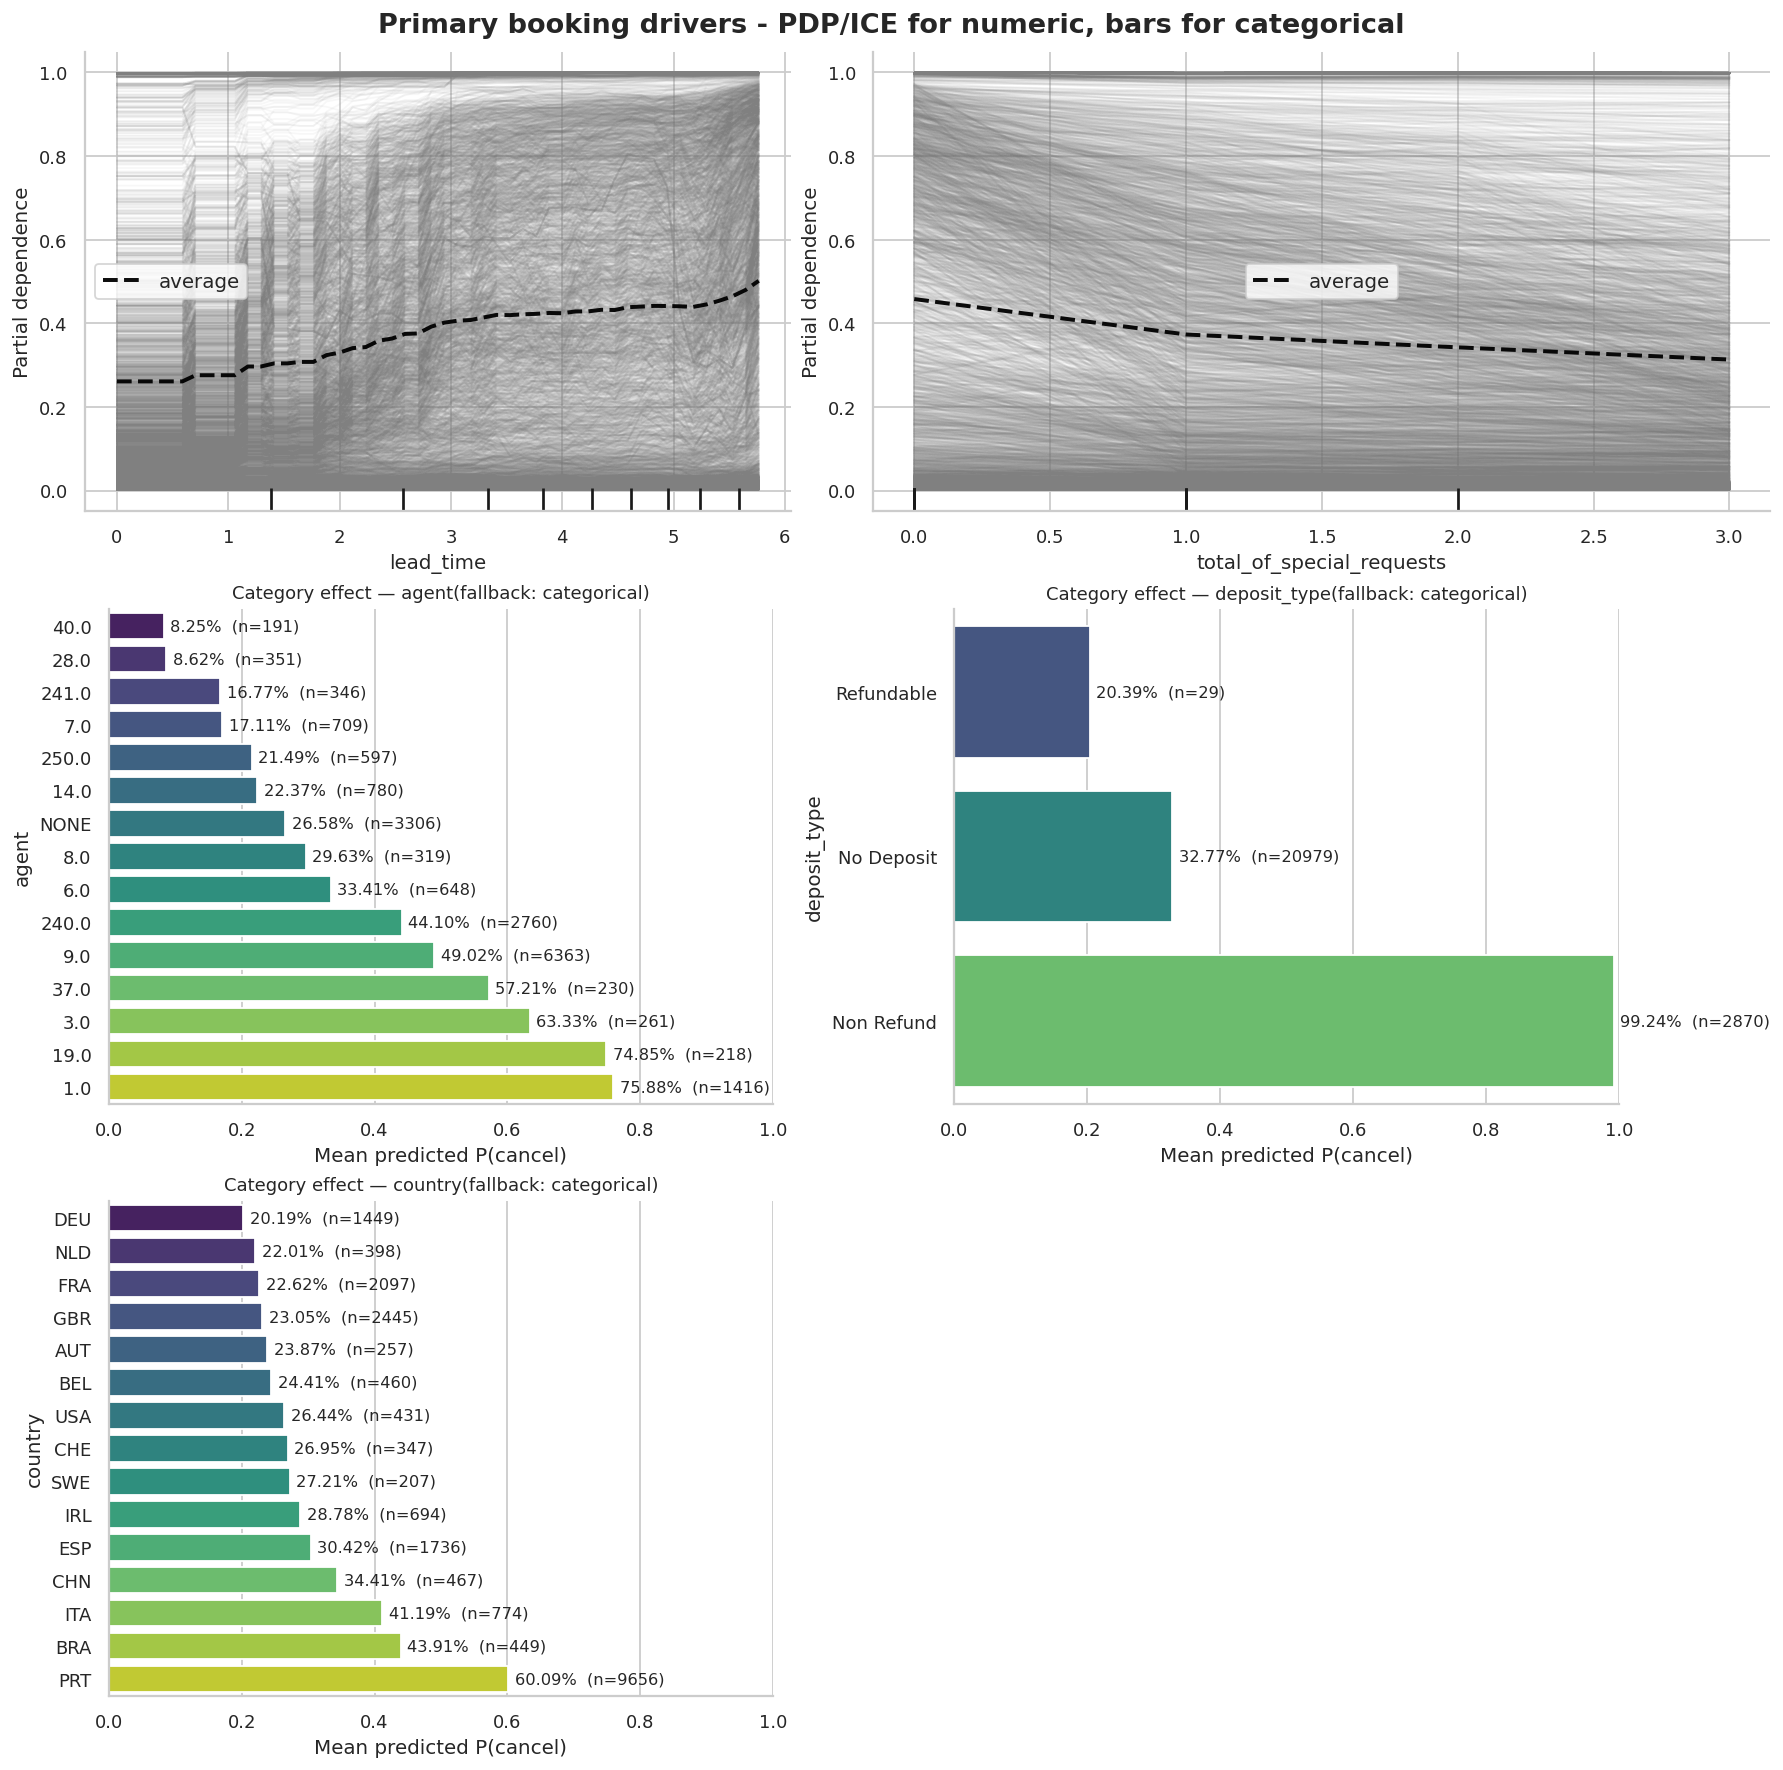

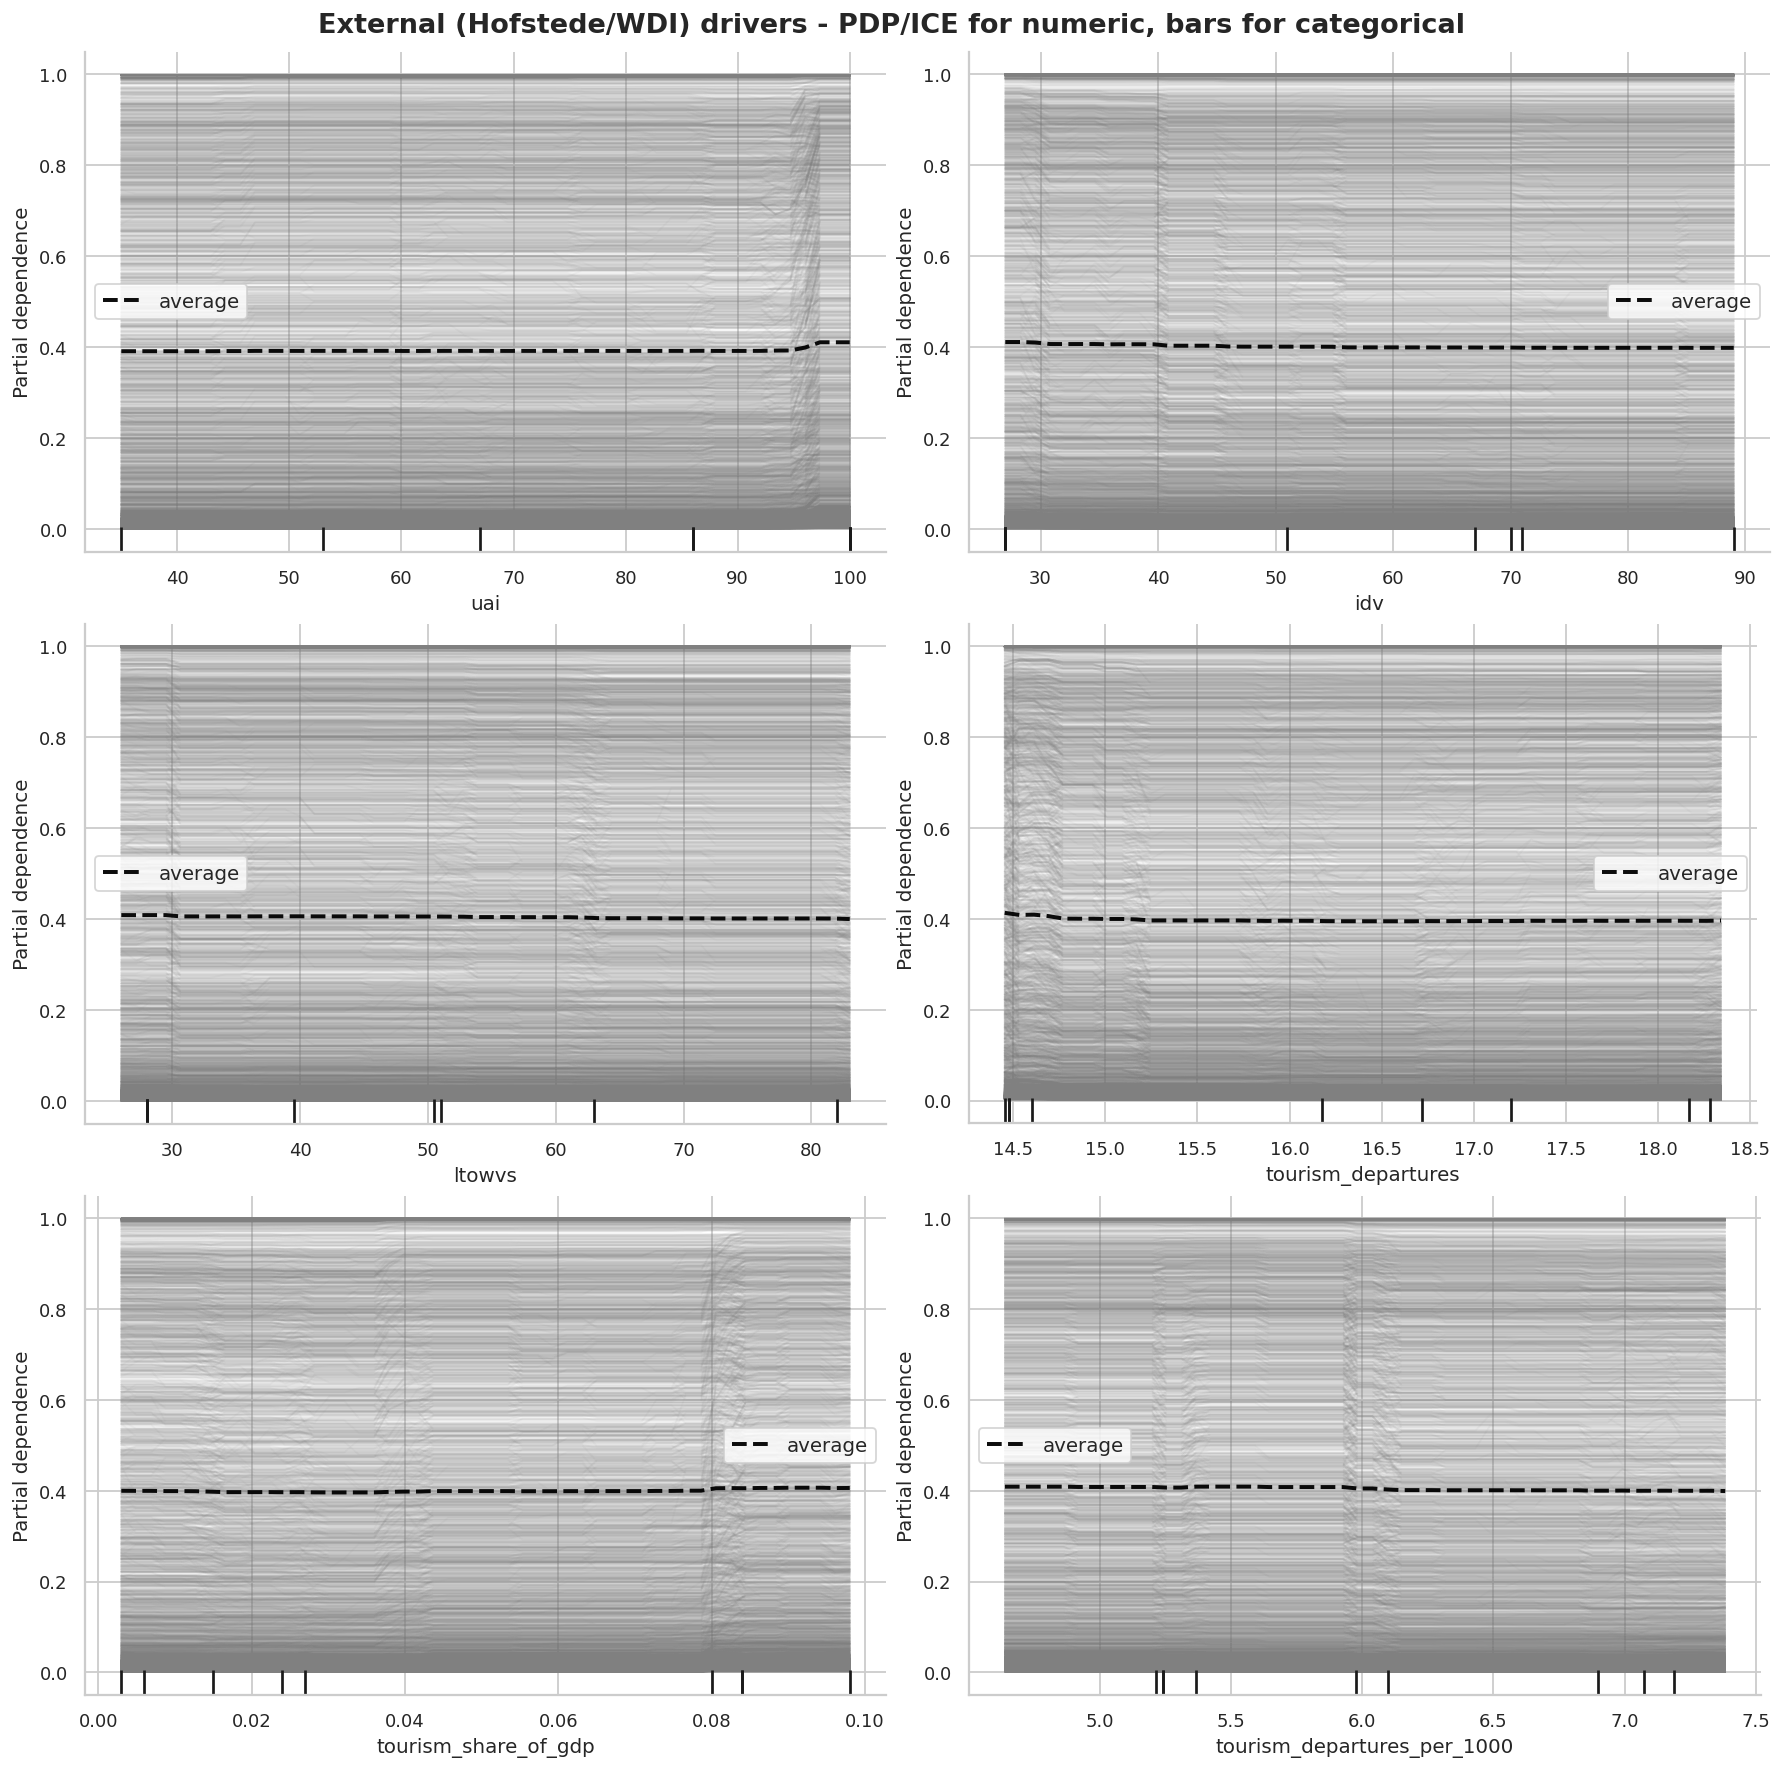

In [ ]:
# Partial-Dependence & ICE

sns.set_theme(context="notebook", style="whitegrid")
plt.rcParams.update({
    "figure.dpi": 130,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

PDP_LINE_KW = dict(color="black", lw=2.2, alpha=0.95)
ICE_LINE_KW = dict(color="grey", alpha=0.06, lw=1.0)
BAR_CMAP = "viridis"

# Helper functions
def _prob_axis(ax):
    """Format y-axis as probability (0–1) with gridlines."""
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda v, p: f"{v:0.2f}"))
    ax.set_ylim(0.0, 1.0)
    ax.grid(True, axis="both", alpha=0.25)

def _neaten(ax, x_label=None, y_label=None, title=None):
    if x_label: ax.set_xlabel(x_label)
    if y_label: ax.set_ylabel(y_label)
    if title:   ax.set_title(title)
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

def _wrap_labels(ax, max_width=22):
    """Wrap long y labels (e.g., country names) so bars don't overflow."""
    # Set a FixedLocator before setting tick labels to avoid warnings
    locs = ax.get_yticks()
    labels = [t.get_text() for t in ax.get_yticklabels()]
    ax.yaxis.set_major_locator(mtick.FixedLocator(locs))
    wrapped = [textwrap.fill(s, max_width) for s in labels]
    ax.set_yticklabels(wrapped)

try:
    champ_raw
except NameError:
    champ_raw = joblib.load("champion_xgb.joblib")["model"]

# Feature lists based on SHAP outputs
# removed 'previous_cancellations' and 'required_car_parking_spaces' as they don't have more than 2 values
candidate_features = [
    # primary booking features
    "lead_time", "total_of_special_requests", "agent", "deposit_type", "country",
    # external (Hofstede + WDI)
    "uai", "idv", "ltowvs",
    "tourism_departures", "tourism_share_of_gdp", "tourism_departures_per_1000"
]

def is_numeric(col: str) -> bool:
    return pd.api.types.is_numeric_dtype(X_test_df[col])

def is_constant(col: str, min_unique: int = 2) -> bool:
    return X_test_df[col].nunique(dropna=False) < min_unique

def ensure_present(cols):
    present = [c for c in cols if c in X_test_df.columns]
    missing = [c for c in cols if c not in X_test_df.columns]
    if missing:
        print(f"Missing in X_test_df: {missing}")
    return present

# Plotting functions
def plot_pdp_numeric(feat: str, ax):
    disp = PartialDependenceDisplay.from_estimator(
        champ_raw, X_test_df, [feat],
        kind="both", # PDP + ICE
        subsample=5_000,
        grid_resolution=50,
        n_jobs=-1,
        line_kw=PDP_LINE_KW,
        ice_lines_kw=ICE_LINE_KW,
        ax=ax
    )
    _prob_axis(ax)
    _neaten(ax, x_label=feat, y_label="Partial dependence", title=f"PDP + ICE — {feat}")
    ax.set_facecolor("#FAFAFA")

def plot_bar_categorical(feat: str, ax, max_levels: int = 15):
    """
    Category effect plot: mean predicted P(cancel) by level.
    """
    p = champ_raw.predict_proba(X_test_df)[:, 1]
    df = pd.DataFrame({feat: X_test_df[feat], "pred": p})

    # most frequent levels only
    top_levels = df[feat].value_counts(dropna=False).head(max_levels).index
    df = df[df[feat].isin(top_levels)]

    agg = (df.groupby(feat, dropna=False)
             .agg(mean_pred=("pred", "mean"), count=("pred", "size"))
             .sort_values("mean_pred", ascending=True)
             .reset_index()
          )
    agg = agg.rename(columns={feat: "level"})

    sns.barplot(
        data=agg, x="mean_pred", y="level",
        hue="level", palette=BAR_CMAP,
        dodge=False, legend=False, ax=ax
    )

    # annotate: probability as %, plus sample size
    for i, (val, n) in enumerate(zip(agg["mean_pred"], agg["count"])):
        ax.text(val + 0.01, i, f"{val:0.2%}  (n={n})", va="center", fontsize=9)

    ax.set_xlim(0, 1)
    _neaten(ax, x_label="Mean predicted P(cancel)", y_label=feat,
            title=f"Category effect — {feat}")
    _wrap_labels(ax, max_width=22)

def feature_grid(features, title, n_cols=2):
    feats = ensure_present(features)
    if not feats:
        print(f"Nothing to plot for: {title}\n")
        return

    n_rows = int(np.ceil(len(feats) / n_cols))
    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(6.8 * n_cols, 4.4 * n_rows),
        constrained_layout=True
    )

    # if grid degenerates to one row/col, ensure axes is iterable
    axes = np.atleast_1d(axes)

    for ax, feat in zip(axes.ravel(), feats):
        try:
            if is_numeric(feat) and not is_constant(feat):
                plot_pdp_numeric(feat, ax)
            else:
                reason = "categorical" if not is_numeric(feat) else "constant"
                plot_bar_categorical(feat, ax)
                ax.set_title(ax.get_title() + f"(fallback: {reason})", fontsize=10)
        except Exception as e:
            ax.axis("off")
            print(f"Skipped '{feat}' → {e}")

    # hide any spare axes
    for ax in axes.ravel()[len(feats):]:
        ax.axis("off")

    fig.suptitle(title, fontsize=15, y=1.02, fontweight="semibold")
    plt.show()

# Run the grids
primary_list = ["lead_time", "total_of_special_requests", "agent", "deposit_type", "country"]
external_list = ["uai", "idv", "ltowvs", "tourism_departures", "tourism_share_of_gdp", "tourism_departures_per_1000"]

feature_grid(primary_list, "Primary booking drivers - PDP/ICE for numeric, bars for categorical")
feature_grid(external_list, "External (Hofstede/WDI) drivers - PDP/ICE for numeric, bars for categorical")


## **Geospatial & Cross-Country Analysis**

In [ ]:
# Setup, sanity checks, and shared helpers
warnings.filterwarnings("ignore", category=UserWarning)
sns.set_theme(context="notebook", style="whitegrid")

# Calibrated champion & threshold
try:
    final_model  # calibrated model
    final_thresh
except NameError as e:
    try:
        raise
    except Exception:
        raise RuntimeError(
            "final_model/final_thresh not found."
        ) from e

# Ensure X_test_df, y_test
try:
    X_test_df
except NameError:
    try:
        # falls back to helper defined earlier
        X_test_df = prepare_test_df(X_train, X_test)
    except Exception as e:
        raise RuntimeError("X_test_df is missing and cannot be prepared."
        ) from e

try:
    y_test
except NameError:
    raise RuntimeError("y_test not found. Run the train/test split earlier.")

# The main required column
required_cols = ["country"]
missing = [c for c in required_cols if c not in X_test_df.columns]
if missing:
    raise RuntimeError(f"Missing required columns in X_test_df: {missing}")

# Output folders
OUT_DIR_FIG = "figs_geo"
OUT_DIR_MAP = "maps_geo"
os.makedirs(OUT_DIR_FIG, exist_ok=True)
os.makedirs(OUT_DIR_MAP, exist_ok=True)

# Build per-booking test frame with calibrated probabilities
y_prob = final_model.predict_proba(X_test_df)[:, 1]
df_test = pd.DataFrame({
    "country": X_test_df["country"].astype(str),
    "y_true": y_test.values,
    "y_prob": y_prob,
    "y_pred": (y_prob >= float(final_thresh)).astype(int)
})
# Use arrival_year in trends
if "arrival_year" in X_test_df.columns:
    df_test["arrival_year"] = X_test_df["arrival_year"]

# Country aggregation with simple Bayesian shrinkage (protects tiny n)
def country_summary(df: pd.DataFrame, m: int = 150):
    """
    Returns per-country table with:
      bookings, observed rate, smoothed observed rate, mean predicted risk,
      predicted positives, lift vs overall, booking share.
    m = prior strength (higher → stronger shrink to global mean for small n).
    """
    g = (df
         .groupby("country", dropna=False)
         .agg(bookings=("y_true", "size"),
              obs_rate=("y_true", "mean"),
              pred_mean=("y_prob", "mean"),
              pred_pos=("y_pred", "sum"))
         .reset_index())
    overall = df["y_true"].mean()
    g["obs_rate_sm"] = (g["bookings"]*g["obs_rate"] + m*overall) / (g["bookings"] + m)
    g["lift_pred"] = g["pred_mean"] / overall
    g["share_bookings"] = g["bookings"] / g["bookings"].sum()
    g = g.sort_values("pred_mean", ascending=False)
    return g, overall

country_tab, overall_rate = country_summary(df_test, m=150)
print(f"Overall cancellation rate (test set): {overall_rate:.2%}")
display(country_tab.head(10))

Overall cancellation rate (test set): 37.04%


country  bookings  obs_rate  pred_mean  pred_pos  obs_rate_sm  lift_pred  share_bookings
75      MAC         5  1.000000   0.868366         5     0.390734   2.344244        0.000209
117     TZA         1  1.000000   0.792083         1     0.374594   2.138310        0.000042
41      GAB         1  1.000000   0.771592         1     0.374594   2.082992        0.000042
53      IDN         6  0.833333   0.744476         5     0.388229   2.009792        0.000251
106     SUR         1  0.000000   0.695684         1     0.367972   1.878072        0.000042
3       ARE         7  0.857143   0.687348         6     0.392125   1.855568        0.000293
36      EGY         3  1.000000   0.683292         3     0.382769   1.844618        0.000126
50      HKG        12  0.916667   0.680165        11     0.410887   1.836176        0.000503
95      PHL         5  0.800000   0.652202         4     0.384282   1.760686        0.000209
92      PAK         4  0.750000   0.639709         3     0.380284   1.726962        0.000168

In [ ]:
# Integrity check
ov = overall_rate
g  = country_tab.copy()

# lift = pred_mean / overall
assert np.allclose(g["lift_pred"], g["pred_mean"] / ov, rtol=1e-5, atol=1e-8)

# smoothed observed rate formula
m = 150
obs_sm_recalc = (g["bookings"] * g["obs_rate"] + m * ov) / (g["bookings"] + m)
assert np.allclose(g["obs_rate_sm"], obs_sm_recalc, rtol=1e-5, atol=1e-8)

# share_bookings sums to 1
assert abs(g["share_bookings"].sum() - 1.0) < 1e-6
print("Integrity checks done.")


Integrity checks done.


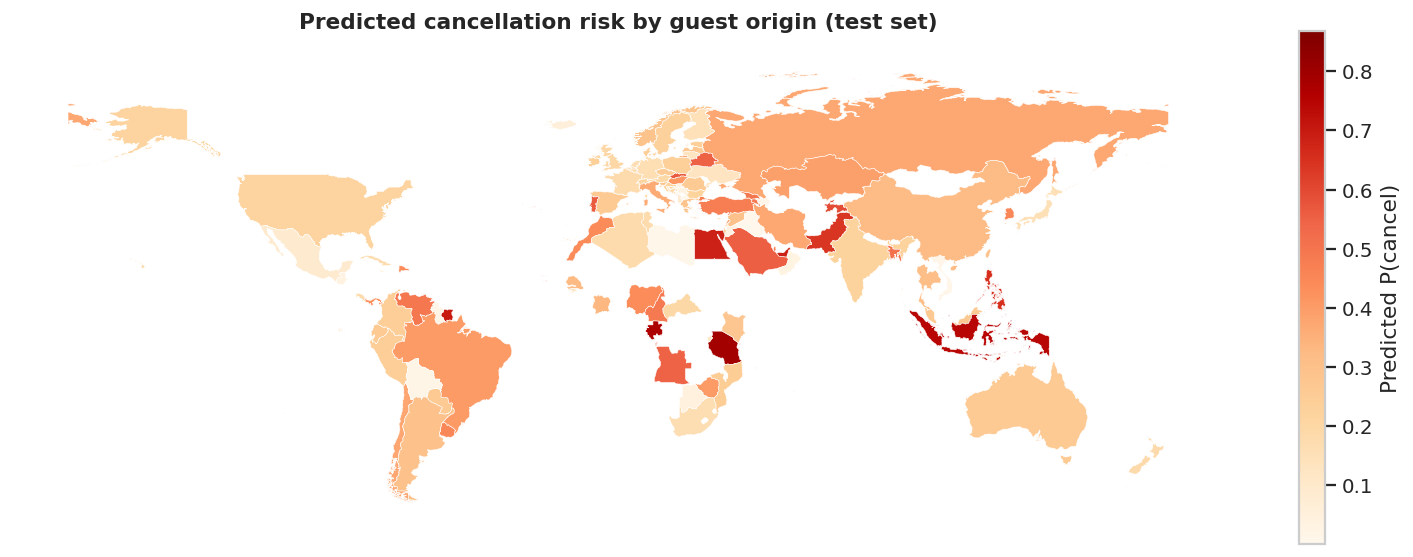

Saved static map :- figs_geo/choropleth_pred_mean.png
Saved interactive map :- maps_geo/pred_risk_by_origin.html


In [ ]:
# Choropleths: static (GeoPandas) & interactive (Folium)
#   -- Uses Natural Earth 50m admin_0 map_units (includes territories)
#   -- Robust Folium bins (no rounding, full coverage)

# Prepare map table (keep UNK in tables but exclude from maps)
country_tab = country_tab.copy()
country_tab["iso3"] = country_tab["country"].astype(str)

# Optional: Stability mask for maps (set to 50 to hide very small-sample countries)
MIN_N_FOR_MAP = 0  # 0 disables masking
plot_col = "pred_mean_map" if MIN_N_FOR_MAP and MIN_N_FOR_MAP > 0 else "pred_mean"

country_tab_map = country_tab.copy()
if plot_col == "pred_mean_map":
    country_tab_map[plot_col] = np.where(
        country_tab_map["bookings"] >= MIN_N_FOR_MAP, country_tab_map["pred_mean"], np.nan
    )
else:
    country_tab_map[plot_col] = country_tab_map["pred_mean"]

# Exclude UNK for maps
country_tab_map = country_tab_map[country_tab_map["iso3"] != "UNK"].copy()

# Load Natural Earth (50m admin_0 map_units, includes micro-states/territories)
NE_URL = "https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_map_units.zip"
world = gpd.read_file(NE_URL)

# Normalize identifiers
iso_candidates = ["ISO_A3_EH", "ISO_A3", "ADM0_A3", "iso_a3"]
name_candidates = ["NAME_EN", "NAME_LONG", "ADMIN", "SOVEREIGNT", "NAME", "name"]

for col in iso_candidates:
    if col in world.columns:
        world["iso3_world"] = world[col].astype(str).str.upper()
        break
else:
    raise RuntimeError("ISO3 column not found in Natural Earth (50m map_units).")

for col in name_candidates:
    if col in world.columns:
        world["name_world"] = world[col].astype(str)
        break
else:
    world["name_world"] = world["iso3_world"]

# Drop Antarctica/unresolved + empty geometries
world = world[~world["iso3_world"].isin(["-99", "ATA"])].copy()
world = world[world.geometry.notna()].copy()
# Cache for later sections
world_50m = world.copy()

# Join on ISO3
gdf = world.merge(country_tab_map, left_on="iso3_world", right_on="iso3", how="left")

# Static choropleth (predicted mean risk)
fig, ax = plt.subplots(figsize=(12, 6))
gdf.plot(
    column=plot_col,
    cmap="OrRd",
    linewidth=0.3,
    edgecolor="white",
    legend=True,
    legend_kwds={"label": "Predicted P(cancel)", "shrink": 0.7},
    ax=ax
)
ax.set_axis_off()
ax.set_title("Predicted cancellation risk by guest origin (test set)", weight="bold", pad=12)
plt.tight_layout()
plt.savefig(f"{OUT_DIR_FIG}/choropleth_pred_mean.png", dpi=180)
plt.show()
print(f"Saved static map :- {OUT_DIR_FIG}/choropleth_pred_mean.png")

# Interactive Folium choropleth - robust bins (no rounding, full coverage)
vals = country_tab_map[plot_col].dropna().astype(float).values
if vals.size == 0:
    raise RuntimeError("No non-NaN risk values available for mapping.")

vmin, vmax = float(np.min(vals)), float(np.max(vals))
if np.isclose(vmin, vmax):
    # Create a tiny spread so Folium can bin
    edges = list(vmin + np.linspace(-1e-9, 1e-9, 6))
else:
    edges = list(np.quantile(vals, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]))
    # Ensure strict monotonicity & full coverage
    edges[0]  = min(edges[0], vmin) - 1e-12
    edges[-1] = max(edges[-1], vmax) + 1e-12
    for i in range(1, len(edges)):
        if edges[i] <= edges[i-1]:
            edges[i] = edges[i-1] + 1e-12

m = folium.Map(location=[20, 0], zoom_start=2, tiles="cartodbpositron")

folium.Choropleth(
    geo_data=gdf.__geo_interface__,
    name="Predicted risk",
    data=country_tab_map,
    columns=["iso3", plot_col],
    key_on="feature.properties.iso3_world",  # normalized ISO3 in GeoJSON
    fill_color="OrRd",
    bins=edges,
    nan_fill_color="#f0f0f0",
    fill_opacity=0.85,
    line_opacity=0.3,
    legend_name="Predicted P(cancel)",
    highlight=True
).add_to(m)

# Tooltip for safety if some fields are NaN
gdf_tip = gdf.fillna({
    "bookings": 0, plot_col: 0, "obs_rate": 0,
    "obs_rate_sm": 0, "lift_pred": 0
})
folium.GeoJson(
    gdf_tip,
    style_function=lambda x: {"color": "#333333", "weight": 0.3, "fillOpacity": 0},
    tooltip=folium.features.GeoJsonTooltip(
        fields=["name_world", "iso3_world", "bookings", plot_col, "obs_rate_sm", "lift_pred"],
        aliases=["Country", "ISO3", "Bookings", "Pred. P(cancel)",
                 "Obs. rate (shrunk)", "Lift vs overall"],
        localize=True
    )
).add_to(m)

m.save(f"{OUT_DIR_MAP}/pred_risk_by_origin.html")
print(f"Saved interactive map :- {OUT_DIR_MAP}/pred_risk_by_origin.html")


In [ ]:
# Validation of the map layer
plot_col = "pred_mean_map" if "pred_mean_map" in gdf.columns else "pred_mean"
mapped = gdf[~gdf[plot_col].isna()]
unmapped = gdf[gdf[plot_col].isna()]

print(f"Countries on map with data: {len(mapped)}")
print(f"Countries without data (blank): {len(unmapped)}")
print("Range on map:", float(mapped[plot_col].min()), "→", float(mapped[plot_col].max()))

# Compare to the table
tab_vals = country_tab.query("country != 'UNK'")[["iso3","pred_mean"]].dropna()
print(f"Table countries (non-UNK) with data: {len(tab_vals)}")
print("Difference (table but not on map):",
      set(tab_vals["iso3"]) - set(mapped["iso3_world"]))
print("Difference (map but missing in table):",
      set(mapped["iso3_world"]) - set(tab_vals["iso3"]))

# Top 10 countries by risk with sample size
tmp = country_tab.query("country != 'UNK'")[["country","bookings","pred_mean"]] \
                 .sort_values("pred_mean", ascending=False).head(10)
display(tmp.style.format({"pred_mean":"{:.2%}"}).set_caption("Top 10 predicted risk (test)"))

Countries on map with data: 136
Countries without data (blank): 124
Range on map: 0.0007936922018416225 → 0.868365707397461
Table countries (non-UNK) with data: 125
Difference (table but not on map): {'GIB'}
Difference (map but missing in table): set()


In [ ]:
# Top/Bottom origin countries & contribution shares

# Params
MIN_N = 50               # set to 100 for stricter stability
EXCLUDE = {"UNK"}        # codes to exclude from ranked lists (UNK - Unknown, Missing Country)

# Build eligible table for ranking
mask_eligible = (country_tab["bookings"] >= MIN_N) & (~country_tab["country"].isin(EXCLUDE))
eligible = (country_tab.loc[mask_eligible,
                            ["country","bookings","pred_mean","obs_rate","obs_rate_sm","lift_pred"]]
                      .sort_values("pred_mean", ascending=True)
                      .reset_index(drop=True))

n_eligible = len(eligible)
if n_eligible == 0:
    raise RuntimeError(f"No countries meet MIN_N={MIN_N} after excluding {sorted(EXCLUDE)}.")

# K ensures top & bottom don’t overlap if n_eligible < 30
k = min(15, n_eligible // 2 if n_eligible >= 2 else 1)

bottom_clean = eligible.head(k).copy()
top_clean    = eligible.tail(k).iloc[::-1].copy()

print(f"Eligible countries (n≥{MIN_N}, excl. {', '.join(sorted(EXCLUDE))}): {n_eligible}, K={k}")

# Tables
print(f"\nBottom {k} origin countries by predicted risk (n >= {MIN_N}):")
display(bottom_clean.style.format({
    "pred_mean": "{:.2%}",
    "obs_rate": "{:.2%}",
    "obs_rate_sm": "{:.2%}",
    "lift_pred": "{:.2f}"
}).set_caption(f"Bottom {k} by predicted P(cancel)"))

print(f"\nTop {k} origin countries by predicted risk (n >= {MIN_N}):")
display(top_clean.style.format({
    "pred_mean": "{:.2%}",
    "obs_rate": "{:.2%}",
    "obs_rate_sm": "{:.2%}",
    "lift_pred": "{:.2f}"
}).set_caption(f"Top {k} by predicted P(cancel)"))

# Contribution to predicted positives (excl. UNK)
contrib_clean = (country_tab.loc[~country_tab["country"].isin(EXCLUDE),
                                 ["country","bookings","pred_pos"]]
                           .assign(pred_pos_share=lambda d: d["pred_pos"] / d["pred_pos"].sum())
                           .sort_values("pred_pos_share", ascending=False)
                           .head(15))

print("\nTop contributors to predicted positives:")
display(contrib_clean.style.format({"pred_pos_share": "{:.2%}"})
                      .set_caption("Share of predicted positives (test set)"))


Eligible countries (n≥50, excl. UNK): 26, K=13

Bottom 13 origin countries by predicted risk (n >= 50):



Top 13 origin countries by predicted risk (n >= 50):



Top contributors to predicted positives:


In [ ]:
# Risk trends over time

if "arrival_year" not in df_test.columns:
    print("arrival_year not available")
else:
    TOPN = 8
    MIN_N_PER_YEAR = 10  # set 0 to disable, increase for stricter stability

    # Filter
    tmp = df_test.loc[df_test["country"].astype(str) != "UNK"].copy()
    tmp["arrival_year"] = pd.to_numeric(tmp["arrival_year"], errors="coerce").astype("Int64")

    # Pick top origins by total volume
    top_origins = tmp["country"].value_counts().head(TOPN).index.tolist()

    # Group with observed=True
    trend = (tmp[tmp["country"].isin(top_origins)]
             .groupby(["country", "arrival_year"], observed=True, dropna=False)
             .agg(
                 obs_rate=("y_true", "mean"),
                 pred_mean=("y_prob", "mean"),
                 n=("y_true", "size")
             )
             .reset_index())

    # optional stability per point
    if MIN_N_PER_YEAR and MIN_N_PER_YEAR > 0:
        trend = trend[trend["n"] >= MIN_N_PER_YEAR]

    # Plot
    years = sorted(trend["arrival_year"].dropna().unique())
    plt.figure(figsize=(10, 6))
    for c in top_origins:
        sub = trend[trend["country"] == c].sort_values("arrival_year")
        if sub.empty:
            continue
        plt.plot(sub["arrival_year"].astype(int), sub["pred_mean"], marker="o", label=c)

    plt.ylabel("Predicted P(cancel)")
    plt.xlabel("Arrival year")
    plt.title("Predicted cancellation risk over time – top origins by volume")
    if len(top_origins) <= 12:
        plt.legend(ncol=2, fontsize=9)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"{OUT_DIR_FIG}/risk_trend_top_origins.png", dpi=160)
    plt.show()
    print(f"Saved trend plot :- {OUT_DIR_FIG}/risk_trend_top_origins.png")


Saved trend plot :- figs_geo/risk_trend_top_origins.png


In [ ]:
# Cross-country drivers (Hofstede + WDI) with FDR control

# Feature lists
wdi_candidates = [
    'population_density','inflation_pct','mobile_subs_per100','internet_users_pct',
    'gdp_growth_pct','gdp_per_capita_usd','unemployment_pct','pop_15_64_pct',
    'pop_65_plus_pct','population_total','urban_pop_pct','tourism_departures',
    'tourism_receipts_usd', 'tourism_departures_per_1000', 'tourism_receipts_per_capita',
    'tourism_share_of_gdp', 'real_gdp_growth_pct', 'digital_penetration_index', 'dependency_ratio'
]
hof_cols = ['pdi','idv','mas','uai','ltowvs','ivr']

SIGNIF_Q = 0.10     # FDR threshold for significant features
MIN_COUNTRIES = 8   # min countries with data for the features to be tested

# Exclude UNK
ext_cols = [c for c in (hof_cols + wdi_candidates) if c in X_test_df.columns]
if not ext_cols:
    raise RuntimeError("None of the Hofstede/WDI columns are present in X_test_df.")

mask_valid_ctry = (df_test["country"].astype(str) != "UNK")

tmp = pd.concat(
    [df_test.loc[mask_valid_ctry, ["country"]],
     X_test_df.loc[mask_valid_ctry, ext_cols].astype("float32")],
    axis=1
)

# Per-country aggregation
per_country = tmp.groupby("country", dropna=True).agg({**{c: "mean" for c in ext_cols}})
per_country["risk"] = df_test.loc[mask_valid_ctry].groupby("country")["y_prob"].mean()
per_country["bookings"] = df_test.loc[mask_valid_ctry].groupby("country").size()

# Correlations: Spearman (rank-robust) + bookings-weighted Pearson
rows = []
for c in ext_cols:
    x, y, w = per_country[c], per_country["risk"], per_country["bookings"]
    m = x.notna() & y.notna()
    n = int(m.sum())
    if n < MIN_COUNTRIES:
        continue

    # Spearman
    rho, p = spearmanr(x[m], y[m])

    # Weighted Pearson (bookings as weights)
    ww = (w[m] / w[m].sum()).values
    xv, yv = x[m].values.astype("float64"), y[m].values.astype("float64")
    mx, my = np.sum(ww * xv), np.sum(ww * yv)
    cov = np.sum(ww * (xv - mx) * (yv - my))
    vx = np.sum(ww * (xv - mx)**2)
    vy = np.sum(ww * (yv - my)**2)
    r_w = cov / np.sqrt(vx * vy) if vx > 0 and vy > 0 else np.nan

    rows.append({
        "feature": c,
        "N_countries": n,
        "spearman_rho": rho,
        "p_value": p,
        "weighted_pearson_r": r_w
    })

df_ext_corr = pd.DataFrame(rows)
if df_ext_corr.empty:
    raise RuntimeError("No features had sufficient cross-country coverage to test.")

# Benjamini–Hochberg FDR (q-values), monotone & safe
p = df_ext_corr["p_value"].values
order = np.argsort(p) # ascending p
rank = np.empty_like(order, dtype=float)
rank[order] = np.arange(1, len(p)+1)
m = len(p)
q_vals = p * m / rank # raw BH
# make q monotone non-decreasing when sorted by p
q_sorted = np.minimum.accumulate(np.flip(np.sort(q_vals)))
q_vals_mono = np.empty_like(q_vals)
q_vals_mono[order] = np.flip(q_sorted)
df_ext_corr["q_value"] = np.clip(q_vals_mono, 0, 1)

# Rank by Spearman
df_ext_corr = (df_ext_corr
               .sort_values("spearman_rho", key=lambda s: s.abs(), ascending=False)
               .reset_index(drop=True))

display(
    df_ext_corr.style.format({
        "spearman_rho": "{:.2f}",
        "weighted_pearson_r": "{:.2f}",
        "p_value": "{:.4f}",
        "q_value": "{:.3f}"
    }).set_caption("Cross-country associations with predicted risk")
)


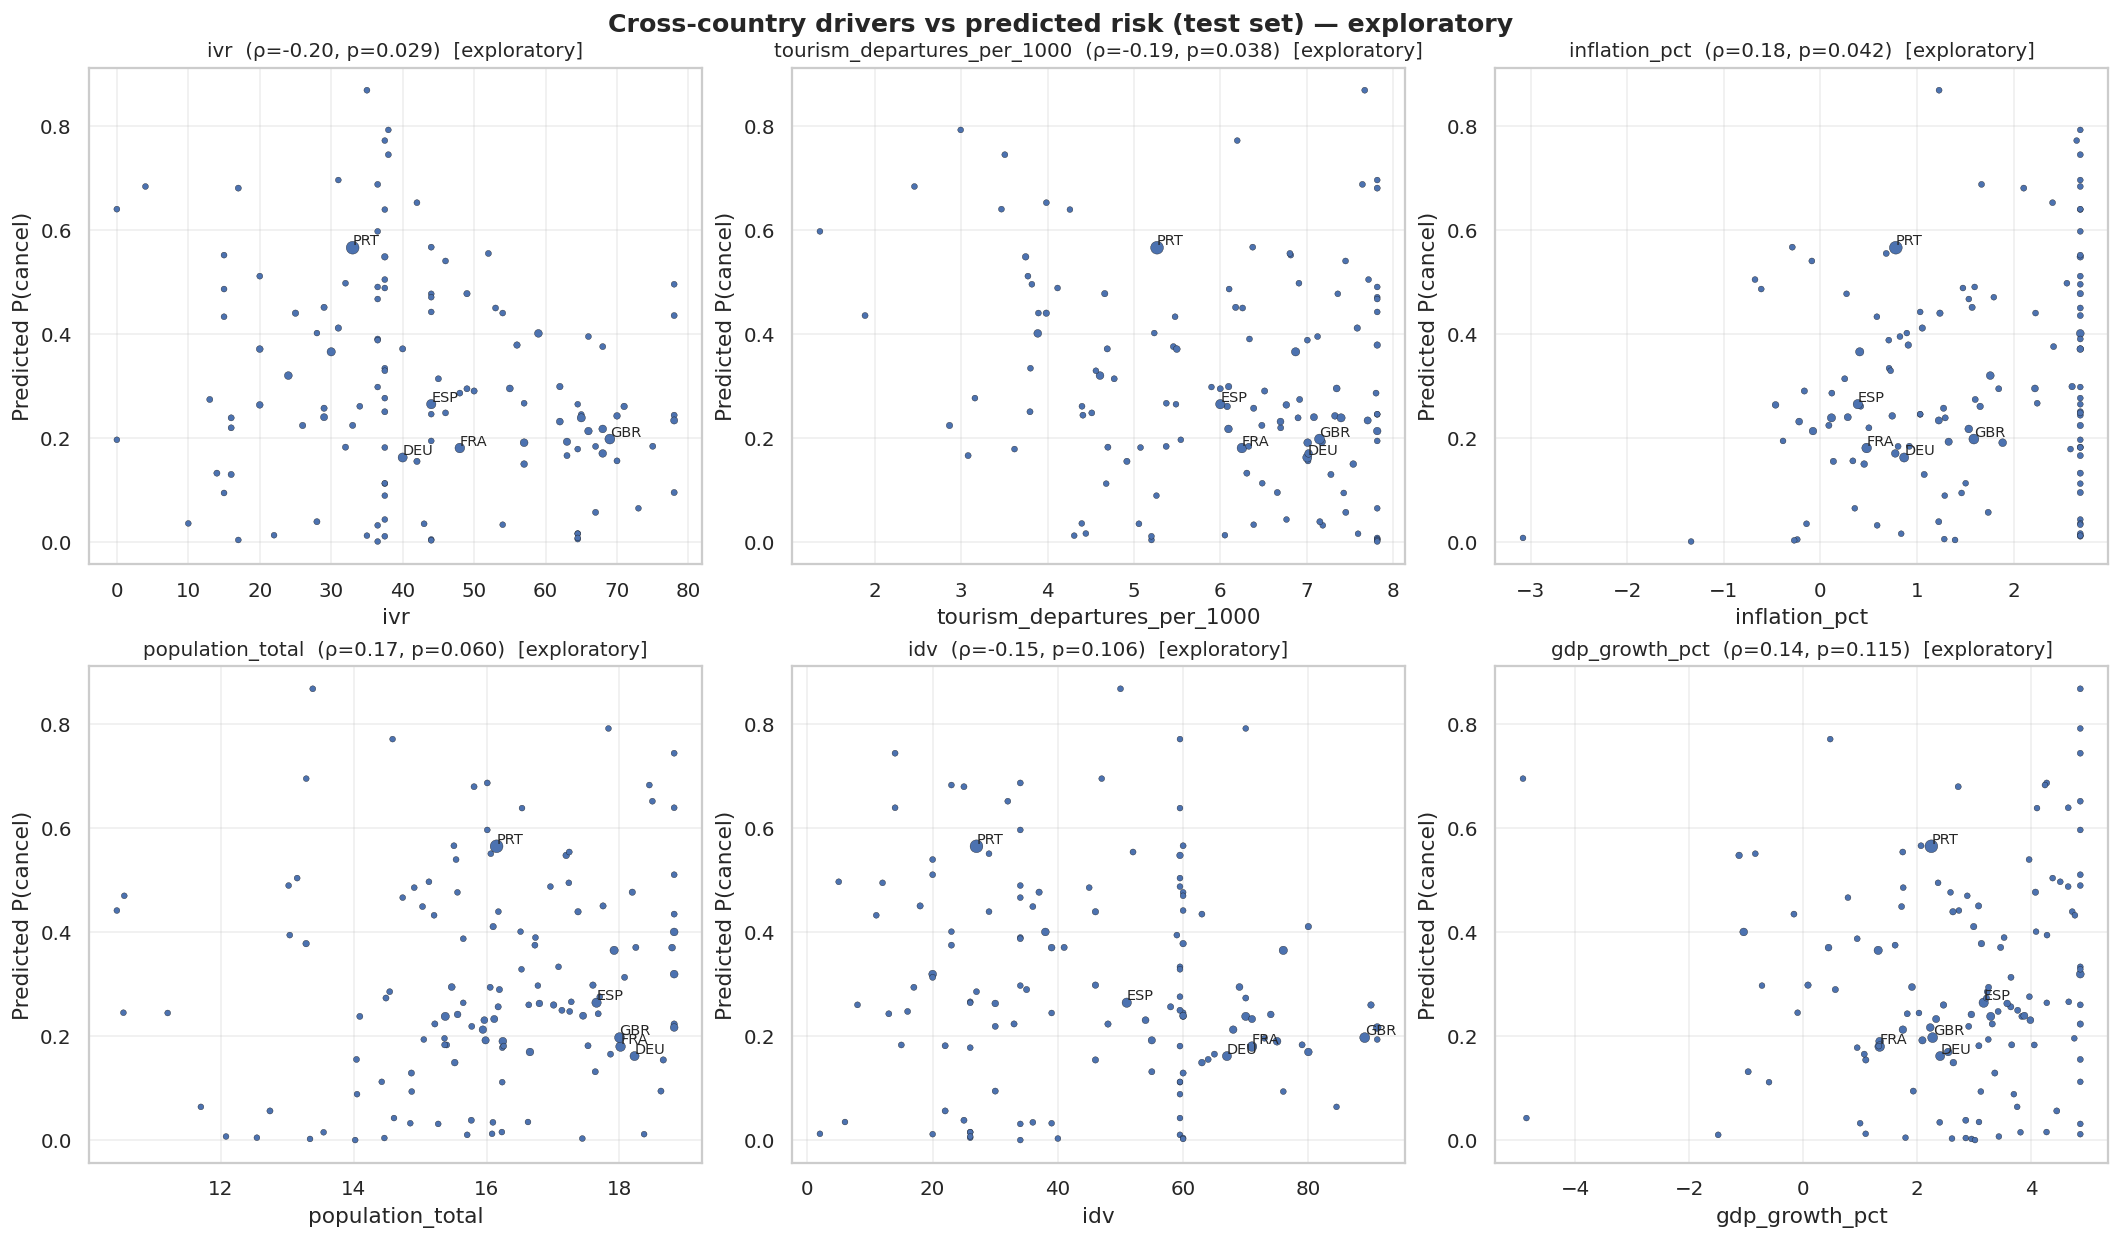

Saved driver scatter grid :- figs_geo/cross_country_driver_scatter.png


In [ ]:
# Cross-country driver plots (Exploratory)

# Reuse per_country
per_country_plot = per_country.reset_index().copy()

top_drivers = []
if 'df_ext_corr' in globals() and not df_ext_corr.empty:
    top_drivers = (df_ext_corr
                   .assign(abs_rho=lambda d: d['spearman_rho'].abs())
                   .sort_values('abs_rho', ascending=False)
                   .head(6)['feature'].tolist())
EXPLORATORY = True

features_to_plot = [c for c in top_drivers if c in per_country_plot.columns]
if not features_to_plot:
    print("No features available to plot.")
else:
    # Small-multiples scatter with size=bookings
    n = len(features_to_plot)
    ncols = 3
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(5.4*ncols, 4.6*nrows), constrained_layout=True)
    axes = np.atleast_1d(axes).ravel()

    for ax, feat in zip(axes, features_to_plot):
        dfp = per_country_plot[['country', feat, 'risk', 'bookings']].dropna().copy()
        if dfp.empty:
            ax.axis('off'); continue

        # scale point sizes by sqrt(bookings) for visibility
        size = 40 * np.sqrt(dfp['bookings'] / (dfp['bookings'].max() + 1e-9)) + 10

        # Spearman on plotted subset
        rho, p = spearmanr(dfp[feat], dfp['risk'])
        sns.scatterplot(data=dfp, x=feat, y='risk', s=size, ax=ax, edgecolor='k', linewidth=0.2)

        # annotate top-5 by bookings
        top5 = dfp.nlargest(5, 'bookings')
        for _, r in top5.iterrows():
            ax.text(r[feat], r['risk'], str(r['country']), fontsize=8, ha='left', va='bottom')

        ax.set_xlabel(feat)
        ax.set_ylabel("Predicted P(cancel)")
        title = f"{feat}  (ρ={rho:.2f}, p={p:.3f})"
        if EXPLORATORY:
            title += "  [exploratory]"
        ax.set_title(title, fontsize=11)
        ax.grid(alpha=0.3)

    # hides empty axes
    for ax in axes[n:]:
        ax.axis('off')

    supt = "Cross-country drivers vs predicted risk (test set)"
    if EXPLORATORY:
        supt += " — exploratory"
    fig.suptitle(supt, fontsize=14, y=1.02, weight="semibold")
    out_path = f"{OUT_DIR_FIG}/cross_country_driver_scatter.png"
    plt.savefig(out_path, dpi=160, bbox_inches='tight')
    plt.show()
    print("Saved driver scatter grid :-", out_path)

    # Summary table for the plotted features
    rows = []
    for feat in features_to_plot:
        s = per_country_plot[[feat, 'risk', 'bookings']].dropna()
        if s.empty:
            continue
        rho, p = spearmanr(s[feat], s['risk'])
        # bookings-weighted Pearson (same as above section)
        w = s['bookings'].values
        ww = w / w.sum()
        x = s[feat].values.astype('float64'); y = s['risk'].values.astype('float64')
        mx, my = (ww * x).sum(), (ww * y).sum()
        cov = (ww * (x-mx) * (y-my)).sum()
        vx  = (ww * (x-mx)**2).sum(); vy = (ww * (y-my)**2).sum()
        r_w = cov / np.sqrt(vx*vy) if vx>0 and vy>0 else np.nan
        rows.append(dict(feature=feat, N_countries=len(s), spearman_rho=rho, p_value=p, weighted_pearson_r=r_w))

    df_plot_summary = (pd.DataFrame(rows)
                       .sort_values('spearman_rho', key=lambda s: s.abs(), ascending=False))
    display(df_plot_summary.style.format({
        "spearman_rho":"{:.2f}", "p_value":"{:.3f}", "weighted_pearson_r":"{:.2f}"
    }).set_caption("Summary for plotted features (test set)"))


In [ ]:
# Group permutation importance (Country vs Externals)
#   -- Tests four sets: COUNTRY, EXT, COUNTRY+EXT, and EXT permuted within-country
#   -- Reports AUC, Brier, ECE

# Define groups in X_test_df
COUNTRY = ['country'] if 'country' in X_test_df.columns else []
EXT = [c for c in (hof_cols + wdi_candidates) if c in X_test_df.columns]

def _ece(y_true, y_prob, n_bins=10):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    idx = np.digitize(y_prob, bins[1:-1])
    ece = 0.0
    for i in range(n_bins):
        m = (idx == i)
        if not np.any(m):
            continue
        ece += m.mean() * abs(y_true[m].mean() - y_prob[m].mean())
    return float(ece)

def _permute_cols_inplace(df, cols, rng):
    for c in cols:
        df[c] = df[c].sample(frac=1.0, random_state=rng.integers(1, 10**9)).values

def _permute_within_group_inplace(df, cols, group_col, rng):
    # shuffle each column within each group (e.g., within country)
    for c in cols:
        df[c] = (df.groupby(group_col, dropna=False)[c]
                   .transform(lambda s: s.sample(frac=1.0, random_state=rng.integers(1, 10**9)).values))

def group_perm_eval(pipe, X_df, y, cols, n_rounds=30, within_group=None, seed=42):
    """
    Permute 'cols' jointly, recompute metrics each round.
    within_group='country' :- permute inside each country (conditional importance).
    """
    if not cols:
        return dict(delta_auc=np.nan, delta_brier=np.nan, delta_ece=np.nan,
                    base_auc=np.nan, base_brier=np.nan, base_ece=np.nan, rounds=0)

    rng = np.random.default_rng(seed)
    base_prob = pipe.predict_proba(X_df)[:, 1]
    base_auc = roc_auc_score(y, base_prob)
    base_brier = brier_score_loss(y, base_prob)
    base_ece = _ece(y.values, base_prob)

    dA, dB, dE = [], [], []
    for _ in range(n_rounds):
        Xp = X_df.copy()
        if within_group is None:
            _permute_cols_inplace(Xp, cols, rng)
        else:
            _permute_within_group_inplace(Xp, cols, within_group, rng)
        p = pipe.predict_proba(Xp)[:, 1]
        dA.append(base_auc - roc_auc_score(y, p))
        dB.append(base_brier - brier_score_loss(y, p))
        dE.append(base_ece - _ece(y.values, p))

    return dict(
        delta_auc=np.mean(dA), delta_auc_sd=np.std(dA, ddof=1),
        delta_brier=np.mean(dB), delta_brier_sd=np.std(dB, ddof=1),
        delta_ece=np.mean(dE), delta_ece_sd=np.std(dE, ddof=1),
        base_auc=base_auc, base_brier=base_brier, base_ece=base_ece, rounds=n_rounds
    )

# Run the four tests
results = []
results.append(("COUNTRY", group_perm_eval(final_model, X_test_df, y_test, COUNTRY, n_rounds=30)))
results.append(("EXT", group_perm_eval(final_model, X_test_df, y_test, EXT, n_rounds=30)))
results.append(("COUNTRY+EXT", group_perm_eval(final_model, X_test_df, y_test, COUNTRY+EXT, n_rounds=30)))
if COUNTRY:
    results.append(("EXT | within-country", group_perm_eval(final_model, X_test_df, y_test, EXT, n_rounds=30, within_group='country')))

# Table
tab = (pd.DataFrame(
        [{**{"Group": name}, **stats} for name, stats in results]
      )[["Group","rounds","base_auc","base_brier","base_ece",
         "delta_auc","delta_auc_sd","delta_brier","delta_brier_sd","delta_ece","delta_ece_sd"]]
      .rename(columns={"rounds":"N"})
     )

display(tab.style.format({
    "base_auc":"{:.4f}","base_brier":"{:.4f}","base_ece":"{:.4f}",
    "delta_auc":"{:.4f}","delta_auc_sd":"{:.4f}",
    "delta_brier":"{:.5f}","delta_brier_sd":"{:.5f}",
    "delta_ece":"{:.5f}","delta_ece_sd":"{:.5f}"
}).set_caption("Group permutation importance on the test set"))


Saved bivariate map :- figs_geo/bivariate_risk_ivr.png


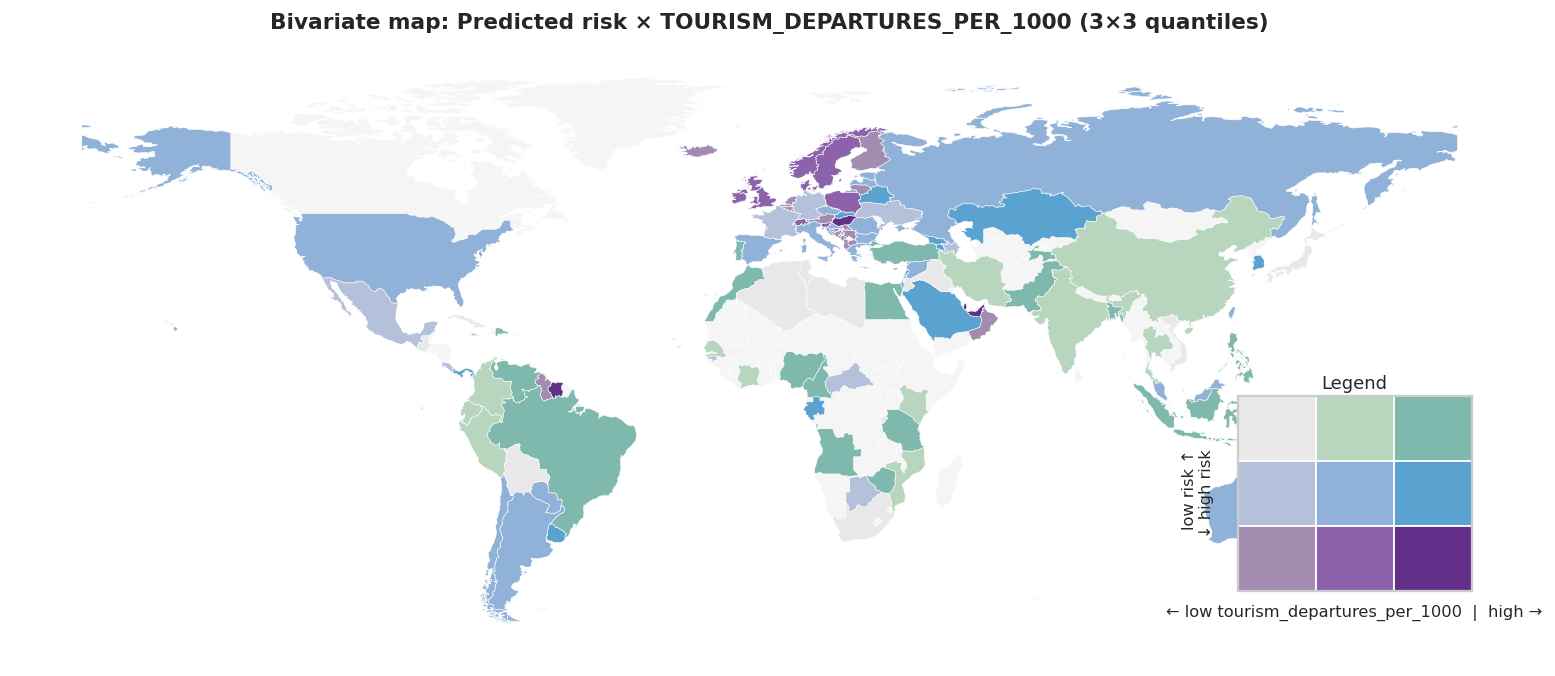

Saved bivariate map :- figs_geo/bivariate_risk_tourism_departures_per_1000.png


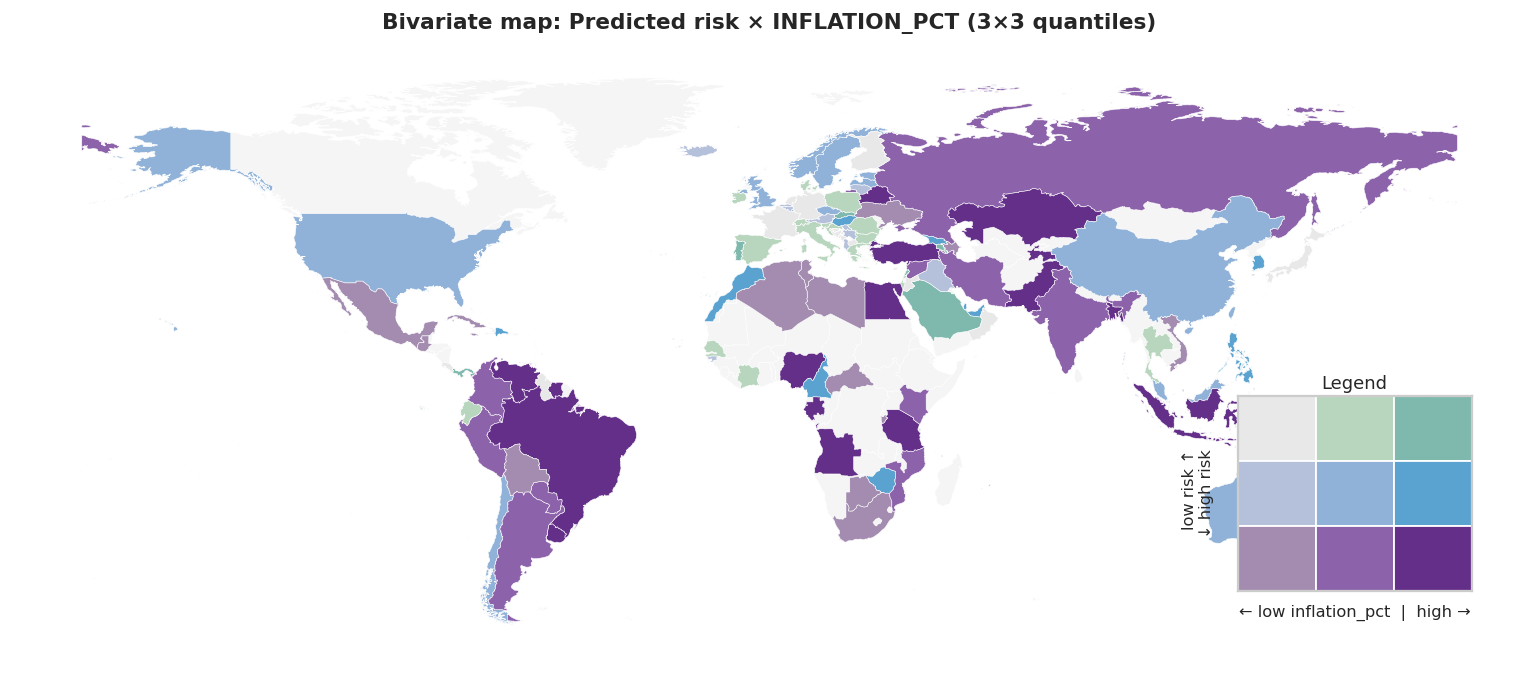

Saved bivariate map :- figs_geo/bivariate_risk_inflation_pct.png


In [ ]:
# Bivariate maps for Top 3

# Pick which drivers to plot
MAX_DRIVERS = 3
fallback = ['ivr','inflation_pct','tourism_departures_per_1000']
pool = (top_drivers if 'top_drivers' in globals() and top_drivers else fallback)
drivers_to_plot = [c for c in pool if c in X_test_df.columns][:MAX_DRIVERS]

if not drivers_to_plot:
    print("No suitable external drivers available in X_test_df; skipping 16h.")
else:
    # reuse 50m world
    try:
        world = world_50m.copy()
    except NameError:
        raise RuntimeError("world_50m not found")

    palette = [
        "#e8e8e8", "#b8d6be", "#7fb8ad",
        "#b5c0da", "#90b2d8", "#5aa2cf",
        "#a38cb0", "#8c62aa", "#642f89"
    ]

    def plot_bivariate(driver: str):
        mask = df_test["country"].astype(str) != "UNK"
        tmp = pd.concat([df_test.loc[mask, ["country","y_prob"]],
                         X_test_df.loc[mask, [driver]].astype("float32")], axis=1)
        bi = (tmp.groupby("country", dropna=True)
                .agg(driver=(driver,"mean"), risk=("y_prob","mean"),
                     bookings=("y_prob","size"))
                .reset_index().rename(columns={"country":"iso3"}))

        # 3×3 quantile bins (robust to ties)
        drv_q = pd.qcut(bi["driver"], 3, labels=[0,1,2], duplicates="drop")
        rsk_q = pd.qcut(bi["risk"],   3, labels=[0,1,2], duplicates="drop")
        n_drv = drv_q.cat.categories.size if hasattr(drv_q, "cat") else 0
        n_rsk = rsk_q.cat.categories.size if hasattr(rsk_q, "cat") else 0
        if n_drv < 2 or n_rsk < 2:
            print(f"Skipping {driver}: insufficient spread ({n_drv}×{n_rsk}).")
            return

        bi["drv_bin"] = drv_q.astype(int)
        bi["rsk_bin"] = rsk_q.astype(int)
        bi["class"] = bi["drv_bin"] * 3 + bi["rsk_bin"]

        gbi = world.merge(bi, left_on="iso3_world", right_on="iso3", how="left")

        fig, ax = plt.subplots(figsize=(12, 6))
        gbi.plot(color="#f5f5f5", linewidth=0.3, edgecolor="white", ax=ax)  # base
        gd = gbi.dropna(subset=["class"]).copy()
        gd.plot(color=[palette[int(i)] for i in gd["class"].clip(0,8)],
                linewidth=0.3, edgecolor="white", ax=ax)
        ax.set_axis_off()
        ax.set_title(f"Bivariate map: Predicted risk × {driver.upper()} (3×3 quantiles)", weight="bold", pad=12)

        # 3×3 legend
        legend_ax = fig.add_axes([0.80, 0.20, 0.15, 0.25])
        legend_ax.set_xticks([]); legend_ax.set_yticks([]); legend_ax.set_frame_on(True)
        legend_ax.set_title("Legend", fontsize=10, pad=4)
        for i in range(3):
            for j in range(3):
                idx = i*3 + j
                legend_ax.add_patch(Rectangle((j/3, (2-i)/3), 1/3, 1/3,
                                              facecolor=palette[idx], edgecolor="white"))
        legend_ax.text(0.5, -0.07, f"← low {driver}  |  high →", ha="center", va="top", fontsize=9, transform=legend_ax.transAxes)
        legend_ax.text(-0.10, 0.5, "low risk ↑\n↓ high risk", ha="right", va="center", fontsize=9, rotation=90, transform=legend_ax.transAxes)

        out_png = f"{OUT_DIR_FIG}/bivariate_risk_{driver}.png"
        plt.tight_layout()
        plt.savefig(out_png, dpi=180, bbox_inches="tight")
        plt.show()
        print(f"Saved bivariate map :- {out_png}")

    for d in drivers_to_plot:
        plot_bivariate(d)


[Global Moran] Predicted cancellation risk — I = 0.0805, p (perm) = 0.0428, n = 136, k = 5


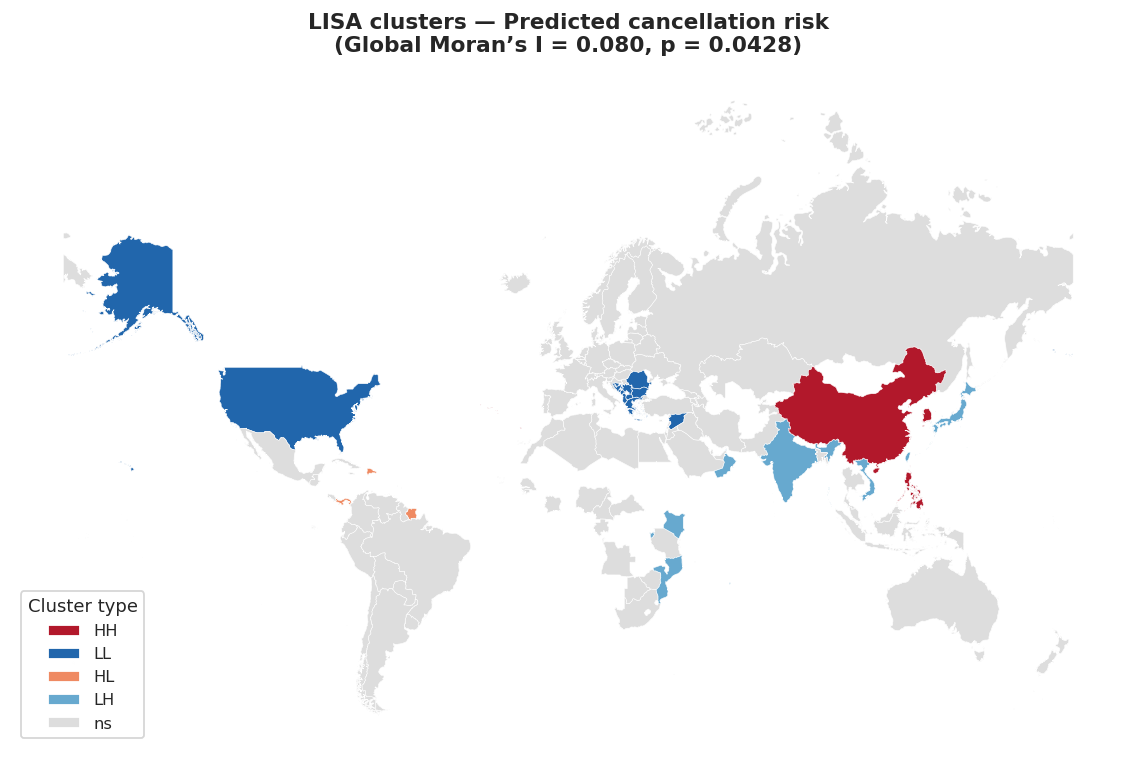

Saved LISA cluster map :- figs_geo/lisa_clusters_pred.png
[Global Moran] Observed cancellation rate (shrunk) — I = 0.4601, p (perm) = 0.0001, n = 136, k = 5


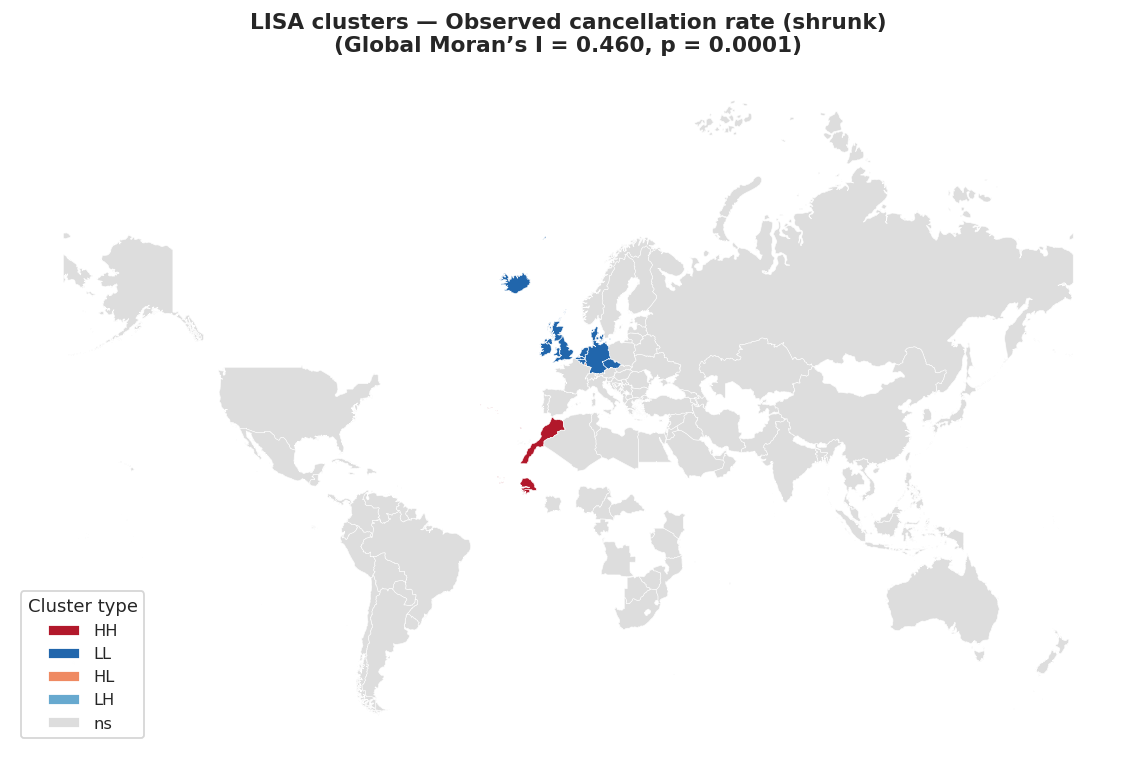

Saved LISA cluster map :- figs_geo/lisa_clusters_obs.png


In [ ]:
# Global Moran’s I + LISA

# Helper functions
def _ensure_metric_crs(gdf_in, crs_epsg=3857):
    gdf = gdf_in.copy()
    if gdf.crs is None:
        try: gdf = gdf.set_crs(4326, allow_override=True)
        except Exception: pass
    try: gdf = gdf.to_crs(crs_epsg)
    except Exception: pass
    return gdf

def _repair_geometries(gdf_in):
    gdf = gdf_in.copy()
    if not gdf.geometry.is_valid.all():
        try: gdf["geometry"] = gdf.geometry.buffer(0)
        except Exception: pass
    gdf = gdf[gdf.geometry.notna()].copy()
    gdf = gdf[gdf.geometry.is_valid].copy()
    return gdf

def _attr_float(obj, name):
    val = getattr(obj, name, None)
    try: return float(val) if val is not None else None
    except Exception: return None

# Main Function
def _run_moran_and_lisa(gdf_source, value_col, title_label, out_stub,
                        k_neighbors=5, permutations=9999, alpha=0.05):
    """
    Global Moran's I + LISA on gdf_source[value_col].
    Displays summary tables and saves cluster map.
    """
    if 'OUT_DIR_FIG' not in globals() or OUT_DIR_FIG is None:
        raise RuntimeError("OUT_DIR_FIG not found")

    gdf_m = gdf_source.dropna(subset=[value_col]).copy()
    gdf_m = _repair_geometries(gdf_m)
    if len(gdf_m) < 3:
        print(f"[Moran] Not enough areas with data for '{value_col}' (n={len(gdf_m)}). Skipping.")
        return None, None, None

    # Metric CRS for KNN and deterministic permutations
    gdf_m = _ensure_metric_crs(gdf_m)
    k = min(max(2, k_neighbors), max(1, len(gdf_m) - 1))
    np.random.seed(42)

    # Row-standardized KNN weights (handles islands)
    w = KNN.from_dataframe(gdf_m, k=k)
    w.transform = 'r'
    y = gdf_m[value_col].values.astype(float)

    # Global Moran
    mi = Moran(y, w, permutations=permutations)
    print(f"[Global Moran] {title_label} — I = {mi.I:.4f}, p (perm) = {mi.p_sim:.4f}, n = {len(gdf_m)}, k = {k}")

    # Local Moran (LISA)
    lisa = Moran_Local(y, w, permutations=permutations)
    gdf_m['lisa_p'] = lisa.p_sim
    gdf_m['lisa_q'] = lisa.q
    gdf_m['lisa_sig'] = gdf_m['lisa_p'] <= alpha
    quad_map = {1:'HH', 2:'LH', 3:'LL', 4:'HL'}
    gdf_m['lisa_cluster'] = np.where(gdf_m['lisa_sig'],
                                     gdf_m['lisa_q'].map(quad_map).fillna('ns'),
                                     'ns')

    # Tables
    summary_df = pd.DataFrame([{
        "value_col": value_col, "n": int(len(gdf_m)),
        "k_neighbors": int(k), "permutations": int(permutations),
        "alpha": float(alpha), "Moran_I": float(mi.I),
        "p_perm": float(mi.p_sim), "z_perm": _attr_float(mi, "z_sim"),
        "E[I]": _attr_float(mi, "EI"), "se_perm": _attr_float(mi, "seI_sim")
    }])
    display(summary_df.style.format({
        "alpha": "{:.2f}", "Moran_I": "{:.3f}", "p_perm": "{:.4f}",
        "z_perm": "{:.3f}", "E[I]": "{:.3f}", "se_perm": "{:.4f}"
    }).set_caption(f"Global Moran's I — {title_label}"))

    counts_df = (gdf_m['lisa_cluster'].value_counts(dropna=False)
                 .rename_axis('cluster').reset_index(name='count'))
    counts_df['share'] = counts_df['count'] / counts_df['count'].sum()
    display(counts_df.style.format({"share": "{:.1%}"})
            .set_caption(f"LISA cluster counts — {title_label}"))

    members_df = (gdf_m.loc[gdf_m['lisa_cluster'] != 'ns',
                            ['iso3_world','name_world','lisa_cluster','lisa_p']]
                  .sort_values(['lisa_cluster','lisa_p']))
    if not members_df.empty:
        display(members_df.head(30).style.format({"lisa_p": "{:.4f}"})
                .set_caption(f"LISA significant members (α={alpha}) — {title_label} (top 30)"))

    # Map
    colors = {'HH':'#b2182b','LL':'#2166ac','HL':'#ef8a62','LH':'#67a9cf','ns':'#dddddd'}
    order = ['HH','LL','HL','LH','ns']
    fig, ax = plt.subplots(figsize=(12, 6))
    gdf_m.plot(ax=ax, color="#f5f5f5", edgecolor="white", linewidth=0.3)
    gdf_m.plot(ax=ax, color=gdf_m['lisa_cluster'].map(colors),
               edgecolor="white", linewidth=0.3)
    ax.set_axis_off()
    ax.set_title(f"LISA clusters — {title_label}\n(Global Moran’s I = {mi.I:.3f}, p = {mi.p_sim:.4f})",
                 weight="bold", pad=10)
    legend_handles = [Patch(facecolor=colors[k], edgecolor='white', label=k) for k in order]
    ax.legend(handles=legend_handles, labels=order, loc='lower left',
              frameon=True, title="Cluster type", fontsize=9, title_fontsize=10)
    out_png = f"{OUT_DIR_FIG}/lisa_clusters_{out_stub}.png"
    plt.tight_layout(); plt.savefig(out_png, dpi=180, bbox_inches='tight'); plt.show()
    print(f"Saved LISA cluster map :- {out_png}")

    return summary_df, counts_df, members_df

FORCE_RERUN = True   # set False to keep guard behavior and avoid duplicate plots

# Clear guard flags if forcing a rerun
if FORCE_RERUN:
    globals().pop("_LISA_PRED_DONE", None)
    globals().pop("_LISA_OBS_DONE", None)

# Predicted risk
if not globals().get("_LISA_PRED_DONE", False):
    risk_col = "pred_mean_map" if "pred_mean_map" in gdf.columns else "pred_mean"
    _ = _run_moran_and_lisa(gdf, risk_col, "Predicted cancellation risk", "pred",
                            k_neighbors=5, permutations=9999, alpha=0.05)
    _LISA_PRED_DONE = True
else:
    print("Predicted-risk LISA already computed, set FORCE_RERUN=True to recompute.")

# Observed (shrunk), only if present
if "obs_rate_sm" in gdf.columns and gdf["obs_rate_sm"].notna().sum() >= 3:
    if not globals().get("_LISA_OBS_DONE", False):
        _ = _run_moran_and_lisa(gdf, "obs_rate_sm",
                                "Observed cancellation rate (shrunk)", "obs",
                                k_neighbors=5, permutations=9999, alpha=0.05)
        _LISA_OBS_DONE = True
    else:
        print("Observed-rate LISA already computed, set FORCE_RERUN=True to recompute.")
else:
    print("[Moran] 'obs_rate_sm' not available or too sparse, skipping observed-rate spatial tests.")
